# 🏥 Explainable Multimodal Clinical AI Assistant

## Project Overview

This notebook builds a **multimodal AI system** that combines:
1. **Fine-tuned CNN** (DenseNet121) for chest X-ray pathology detection
2. **MedGemma 4B** for multimodal clinical reasoning (inference only)
3. **Fusion logic** to merge visual and language-based findings
4. **Grad-CAM** explainability for visual attribution
5. **Uncertainty estimation** with calibrated confidence
6. **Rule-based risk stratification** (Low / Moderate / High)
7. **Structured JSON output** for downstream integration

### Architecture
```
┌─────────────┐    ┌──────────────────┐
│  Chest X-ray │───▶│  DenseNet121 CNN  │──▶ Pathology Probabilities
│   (Image)    │    │  (Fine-tuned)     │──▶ Grad-CAM Heatmap
└─────────────┘    └──────────────────┘
       │                                        │
       │           ┌──────────────────┐         │
       └──────────▶│   MedGemma 4B    │         │
       +symptoms   │ (Inference Only) │         │
                   └──────────────────┘         │
                           │                    │
                   ┌───────▼────────────────────▼──┐
                   │       Fusion Module            │
                   │  (Contradiction Detection,     │
                   │   Confidence Adjustment)       │
                   └───────────────┬────────────────┘
                                  │
                   ┌──────────────▼───────────────┐
                   │   Uncertainty Estimation      │
                   │   Risk Stratification         │
                   │   Structured JSON Output      │
                   └──────────────────────────────┘
```

> ⚠️ **MEDICAL SAFETY DISCLAIMER: For research and educational use only. Not for clinical use.**
> This system is not FDA-approved and should never be used for actual patient diagnosis,
> treatment planning, or clinical decision-making.

In [1]:
# --- 0.1 Install Dependencies ---
!pip install -q torch torchvision torchaudio
!pip install -q transformers accelerate bitsandbytes
!pip install -q scikit-learn matplotlib seaborn
!pip install -q opencv-python-headless pillow pandas numpy tqdm
!pip install -q kaggle

print("✅ All dependencies installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 19.7 MB/s eta 0:00:00
✅ All dependencies installed.


In [2]:
# --- 0.2 Imports ---

import os
import json
import copy
import glob
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import autocast, GradScaler
from torchvision import transforms, models

from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix,
    precision_recall_fscore_support, precision_recall_curve,
)

print(f"✅ All imports successful.")
print(f"   PyTorch : {torch.__version__}")
print(f"   CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU     : {torch.cuda.get_device_name(0)}")

✅ All imports successful.
   PyTorch : 2.9.0+cu128
   CUDA    : True
   GPU     : Tesla T4


In [3]:
# --- 0.3 Device Setup ---

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

if DEVICE == "cuda":
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ Using device: cuda
   GPU Memory: 15.6 GB


In [4]:
# ============================================================================
# SECTION 1 — CONFIGURATION
# ============================================================================

@dataclass
class Config:
    # Data
    data_dir: str = "./data"
    max_samples: int = 11000
    image_size: int = 224
    val_split: float = 0.2

    # Pathologies
    pathologies: tuple = (
        "Atelectasis", "Cardiomegaly", "Effusion",
        "Infiltration", "Mass",
    )
    num_classes: int = 5

    # Model
    freeze_layers: int = 4
    model_save_path: str = "./models/cnn_chest_xray.pth"

    # Training
    batch_size: int = 32
    num_epochs: int = 20
    learning_rate: float = 3e-5
    weight_decay: float = 1e-5
    early_stopping_patience: int = 5
    num_workers: int = 0
    use_mixed_precision: bool = True

    # MedGemma
    medgemma_model_id: str = "google/medgemma-4b-it"
    max_new_tokens: int = 1024

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # Disclaimer
    disclaimer: str = (
        "AI-generated preliminary analysis for research purposes only. "
        "Not a substitute for professional medical evaluation."
    )


CFG = Config()
os.makedirs(CFG.data_dir, exist_ok=True)
os.makedirs(os.path.dirname(CFG.model_save_path), exist_ok=True)

print("✅ Configuration:")
for k, v in CFG.__dict__.items():
    print(f"   {k:30s}: {v}")

✅ Configuration:
   data_dir                      : ./data
   max_samples                   : 11000
   image_size                    : 224
   val_split                     : 0.2
   pathologies                   : ('Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass')
   num_classes                   : 5
   freeze_layers                 : 4
   model_save_path               : ./models/cnn_chest_xray.pth
   batch_size                    : 32
   num_epochs                    : 20
   learning_rate                 : 3e-05
   weight_decay                  : 1e-05
   early_stopping_patience       : 5
   num_workers                   : 0
   use_mixed_precision           : True
   medgemma_model_id             : google/medgemma-4b-it
   max_new_tokens                : 1024
   device                        : cuda
   disclaimer                    : AI-generated preliminary analysis for research purposes only. Not a substitute for professional medical evaluation.


In [5]:
# --- 2.1 Upload Real Labels CSV ---

from google.colab import files

LABELS_PATH = os.path.join(CFG.data_dir, "Data_Entry_2017.csv")

if os.path.exists(LABELS_PATH):
    os.remove(LABELS_PATH)
    print("🗑️  Deleted old labels file.")

print("📂 Please upload Data_Entry_2017.csv (or Data_Entry_2017_v2020.csv)")
uploaded = files.upload()

uploaded_name = list(uploaded.keys())[0]
with open(LABELS_PATH, "wb") as f:
    f.write(uploaded[uploaded_name])

df_check = pd.read_csv(LABELS_PATH)
total_rows = len(df_check)
print(f"\n✅ Saved to {LABELS_PATH}")
print(f"   File size : {os.path.getsize(LABELS_PATH) / 1e6:.1f} MB")
print(f"   Total rows: {total_rows:,}")
print(f"   Columns   : {list(df_check.columns)}")

if total_rows > 50000:
    print(f"\n✅ Confirmed: this is the REAL NIH ChestX-ray14 labels file.")
else:
    print(f"\n⚠️  Warning: only {total_rows:,} rows — this may still be synthetic.")

print(f"\n   Sample entries:")
print(df_check[["Image Index", "Finding Labels"]].head().to_string(index=False))


📂 Please upload Data_Entry_2017.csv (or Data_Entry_2017_v2020.csv)


Saving Data_Entry_2017_v2020.csv to Data_Entry_2017_v2020.csv

✅ Saved to ./data/Data_Entry_2017.csv
   File size : 9.0 MB
   Total rows: 112,120
   Columns   : ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Sex', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]']

✅ Confirmed: this is the REAL NIH ChestX-ray14 labels file.

   Sample entries:
     Image Index         Finding Labels
00000001_000.png           Cardiomegaly
00000001_001.png Cardiomegaly|Emphysema
00000001_002.png  Cardiomegaly|Effusion
00000002_000.png             No Finding
00000003_001.png                 Hernia


In [6]:
# --- 2.2 Download Real X-ray Images from Kaggle ---

from google.colab import files as colab_files

kaggle_key = os.path.expanduser("~/.kaggle/kaggle.json")
if not os.path.exists(kaggle_key):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    print("📂 Upload your kaggle.json API key file:")
    uploaded_key = colab_files.upload()
    !cp kaggle.json ~/.kaggle/kaggle.json
    !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nih-chest-xrays/sample -p {CFG.data_dir} --unzip

IMAGE_DIR = os.path.join(CFG.data_dir, "sample", "images")
all_pngs = glob.glob(os.path.join(IMAGE_DIR, "*.png"))
print(f"✅ Found {len(all_pngs):,} PNG images.")
print(f"   Image directory: {IMAGE_DIR}")

📂 Upload your kaggle.json API key file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
100% 4.19G/4.20G [01:15<00:00, 73.9MB/s]
100% 4.20G/4.20G [01:15<00:00, 59.9MB/s]
✅ Found 5,606 PNG images.
   Image directory: ./data/sample/images


In [7]:
# --- 2.3 Filter Labels to Match Real Images ---

image_names_on_disk = set(os.path.basename(p) for p in glob.glob(os.path.join(IMAGE_DIR, "*.png")))

df_full = pd.read_csv(LABELS_PATH)
df_filtered = df_full[df_full["Image Index"].isin(image_names_on_disk)].copy()

# Create binary pathology columns
for p in CFG.pathologies:
    df_filtered[p] = df_filtered["Finding Labels"].apply(
        lambda x: 1.0 if p in str(x).split("|") else 0.0
    )

# Keep rows with at least one target pathology OR "No Finding"
mask = df_filtered[list(CFG.pathologies)].sum(axis=1) > 0
mask |= df_filtered["Finding Labels"] == "No Finding"
df_filtered = df_filtered[mask].reset_index(drop=True)

# Cap at max_samples
if len(df_filtered) > CFG.max_samples:
    df_filtered = df_filtered.sample(n=CFG.max_samples, random_state=42).reset_index(drop=True)

df_labels_real = df_filtered

print(f"✅ Filtered dataset: {len(df_labels_real):,} samples")
print(f"\n   Label distribution:")
for p in CFG.pathologies:
    count = int(df_labels_real[p].sum())
    print(f"     {p:20s}: {count:5d}  ({count / len(df_labels_real) * 100:.1f}%)")
no_finding = (df_labels_real["Finding Labels"] == "No Finding").sum()
print(f"     {'No Finding':20s}: {no_finding:5d}  ({no_finding / len(df_labels_real) * 100:.1f}%)")

✅ Filtered dataset: 4,995 samples

   Label distribution:
     Atelectasis         :   509  (10.2%)
     Cardiomegaly        :   142  (2.8%)
     Effusion            :   644  (12.9%)
     Infiltration        :   968  (19.4%)
     Mass                :   286  (5.7%)
     No Finding          :  3039  (60.8%)


In [8]:
# --- 2.4 Dataset Class ---

class ChestXrayDataset(Dataset):
    """
    Multi-label chest X-ray dataset.
    Loads real images or generates synthetic fallbacks.
    """

    def __init__(
        self,
        dataframe: pd.DataFrame,
        image_dir: str,
        pathologies: List[str],
        transform=None,
        use_synthetic: bool = True,
    ):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.pathologies = pathologies
        self.transform = transform
        self.use_synthetic = use_synthetic

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["Image Index"])

        if os.path.exists(img_path) and not self.use_synthetic:
            image = Image.open(img_path).convert("RGB")
        else:
            image = self._generate_synthetic_image(row)

        if self.transform:
            image = self.transform(image)

        labels = torch.tensor(
            [row[p] for p in self.pathologies], dtype=torch.float32
        )
        return image, labels

    def _generate_synthetic_image(self, row) -> Image.Image:
        np.random.seed(hash(row["Image Index"]) % (2**31))
        size = CFG.image_size
        y = np.linspace(0, 1, size).reshape(-1, 1)
        x = np.linspace(0, 1, size).reshape(1, -1)
        base = 0.3 + 0.4 * np.exp(-((x - 0.5) ** 2 + (y - 0.4) ** 2) / 0.15)
        noise = np.random.randn(size, size) * 0.05
        img = np.clip(base + noise, 0, 1)

        labels = [row[p] for p in self.pathologies]
        if labels[0] > 0: img[size // 3 : size // 3 + 20, size // 4 : 3 * size // 4] += 0.15
        if labels[1] > 0: cv2.circle(img, (size // 2, size // 2), size // 4, 0.7, -1)
        if labels[2] > 0: img[2 * size // 3 :, :] += 0.2
        if labels[3] > 0:
            for _ in range(5):
                cx, cy = np.random.randint(50, size - 50, 2)
                cv2.circle(img, (int(cx), int(cy)), 20, 0.6, -1)
        if labels[4] > 0:
            cx, cy = np.random.randint(60, size - 60, 2)
            cv2.circle(img, (int(cx), int(cy)), 25, 0.75, -1)

        img = np.clip(img * 255, 0, 255).astype(np.uint8)
        return Image.fromarray(img).convert("RGB")

In [9]:
# --- 2.5 Transforms and DataLoaders ---

def get_transforms(is_training: bool = True) -> transforms.Compose:
    if is_training:
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop((CFG.image_size, CFG.image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(
                degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((CFG.image_size, CFG.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


def create_dataloaders(df: pd.DataFrame, val_split: float = 0.2):
    n_val = int(len(df) * val_split)
    n_train = len(df) - n_val

    ds_train = ChestXrayDataset(
        df, IMAGE_DIR, CFG.pathologies,
        get_transforms(True),
        use_synthetic=False
    )
    ds_val = ChestXrayDataset(
        df, IMAGE_DIR, CFG.pathologies,
        get_transforms(False),
        use_synthetic=False
    )

    indices = list(range(len(df)))
    np.random.seed(42)
    np.random.shuffle(indices)
    train_idx, val_idx = indices[:n_train], indices[n_train:]

    train_loader = DataLoader(
        Subset(ds_train, train_idx),
        batch_size=CFG.batch_size, shuffle=True,
        num_workers=0, pin_memory=True,
    )
    val_loader = DataLoader(
        Subset(ds_val, val_idx),
        batch_size=CFG.batch_size, shuffle=False,
        num_workers=0, pin_memory=True,
    )

    print(f"✅ DataLoaders created (REAL IMAGES):")
    print(f"   Training    : {n_train} samples")
    print(f"   Validation  : {n_val} samples")
    print(f"   Batch size  : {CFG.batch_size}")
    return train_loader, val_loader


train_loader, val_loader = create_dataloaders(df_labels_real, CFG.val_split)

✅ DataLoaders created (REAL IMAGES):
   Training    : 3996 samples
   Validation  : 999 samples
   Batch size  : 32


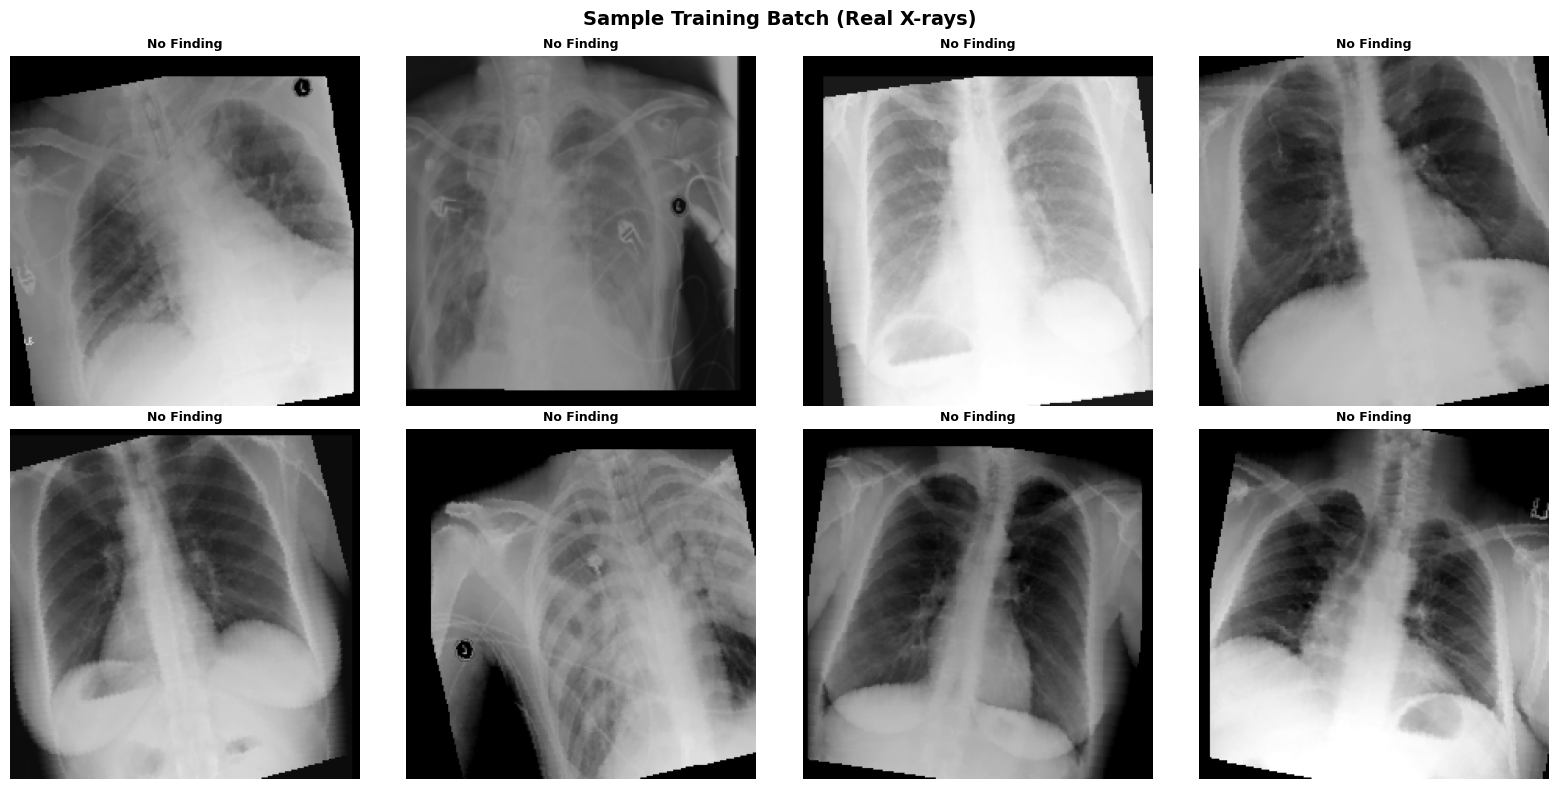

In [10]:
# --- 2.6 Visualize Sample Batch ---

def visualize_batch(loader: DataLoader, pathologies: List[str], n: int = 8):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i, ax in enumerate(axes.flat):
        if i >= n or i >= len(images):
            ax.axis("off")
            continue
        img = (images[i] * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        active = [pathologies[j] for j in range(len(pathologies)) if labels[i][j] > 0.5]
        title = ", ".join(active) if active else "No Finding"
        ax.set_title(title, fontsize=9, fontweight="bold")
        ax.axis("off")

    plt.suptitle("Sample Training Batch (Real X-rays)", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


visualize_batch(train_loader, CFG.pathologies)

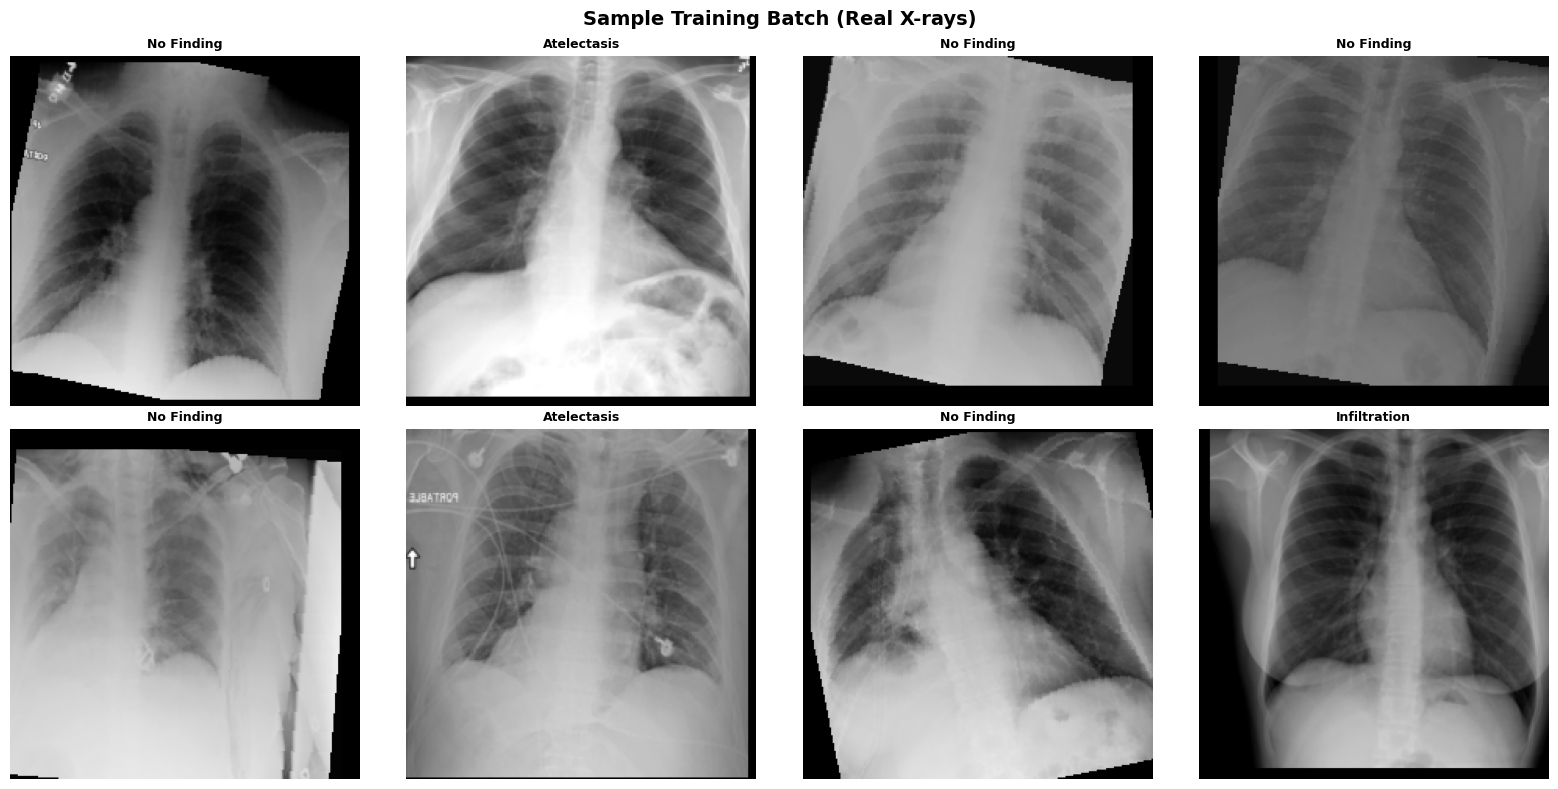

In [11]:


def visualize_batch(loader: DataLoader, pathologies: List[str], n: int = 8):
    """Display a grid of sample images with their labels."""
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i, ax in enumerate(axes.flat):
        if i >= n or i >= len(images):
            ax.axis("off")
            continue
        img = (images[i] * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        active = [pathologies[j] for j in range(len(pathologies)) if labels[i][j] > 0.5]
        title = ", ".join(active) if active else "No Finding"
        ax.set_title(title, fontsize=9, fontweight="bold")
        ax.axis("off")

    plt.suptitle("Sample Training Batch (Real X-rays)", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


visualize_batch(train_loader, CFG.pathologies)

---
## Section 3: CNN Model Fine-Tuning

- **Architecture**: DenseNet121 (pretrained on ImageNet)
- **Strategy**: Freeze early dense blocks, fine-tune later layers + custom head
- **Loss**: `BCEWithLogitsLoss` (multi-label)
- **Optimizer**: Adam with weight decay
- **Mixed precision** training for memory efficiency

In [12]:
# ============================================================================
# SECTION 3 — CNN MODEL FINE-TUNING
# ============================================================================

# --- 3.1 Model Definition ---

class ChestXrayCNN(nn.Module):
    """DenseNet121-based multi-label classifier for chest X-ray pathologies."""

    def __init__(self, num_classes: int, freeze_layers: int = 4):
        super().__init__()
        self.backbone = models.densenet121(
            weights=models.DenseNet121_Weights.IMAGENET1K_V1
        )
        self._freeze_early_layers(freeze_layers)

        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
        self.target_layer = self.backbone.features[-1]

    def _freeze_early_layers(self, n_blocks: int):
        children = list(self.backbone.features.children())
        for i, child in enumerate(children):
            if i < n_blocks:
                for param in child.parameters():
                    param.requires_grad = False
        trainable = sum(p.numel() for p in self.backbone.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.backbone.parameters())
        print(f"   Frozen    : first {n_blocks} feature blocks")
        print(f"   Trainable : {trainable:,} / {total:,} ({trainable / total * 100:.1f}%)")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

    def get_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone.features(x)


print("Building model...")
model = ChestXrayCNN(num_classes=CFG.num_classes, freeze_layers=CFG.freeze_layers)
model = model.to(DEVICE)
print(f"✅ Model ready on {DEVICE}")

Building model...
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 143MB/s]


   Frozen    : first 4 feature blocks
   Trainable : 7,969,320 / 7,978,856 (99.9%)
✅ Model ready on cuda


In [13]:
# --- 3.2 Training Utilities ---

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def compute_auc_scores(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    pathologies: List[str],
) -> Dict[str, float]:
    aucs = {}
    for i, pathology in enumerate(pathologies):
        try:
            auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        except ValueError:
            auc = 0.5
        aucs[pathology] = round(auc, 4)
    aucs["mean"] = round(float(np.mean([v for k, v in aucs.items() if k != "mean"])), 4)
    return aucs

In [14]:
# --- 3.3 Training and Validation Loops ---

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    loss_meter = AverageMeter()

    for images, labels in tqdm(loader, desc="  Training", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast(device_type=device, enabled=CFG.use_mixed_precision):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_meter.update(loss.item(), images.size(0))

    return loss_meter.avg


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    loss_meter = AverageMeter()
    all_labels, all_preds = [], []

    for images, labels in tqdm(loader, desc="  Validating", leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with autocast(device_type=device, enabled=CFG.use_mixed_precision):
            outputs = model(images)
            loss = criterion(outputs, labels)

        loss_meter.update(loss.item(), images.size(0))
        all_labels.append(labels.cpu().numpy())
        all_preds.append(torch.sigmoid(outputs).cpu().numpy())

    return loss_meter.avg, np.vstack(all_labels), np.vstack(all_preds)

In [15]:
# --- 3.4 Execute Training ---

def train_model(model, train_loader, val_loader, config):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=2
    )
    scaler = GradScaler(enabled=config.use_mixed_precision)

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_aucs": [],
        "best_auc": 0.0,
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    print("=" * 60)
    print("TRAINING START (REAL IMAGES)")
    print(f"  Max epochs         : {config.num_epochs}")
    print(f"  Early stopping     : patience = {config.early_stopping_patience}")
    print(f"  LR scheduler       : ReduceLROnPlateau (factor=0.5, patience=2)")
    print("=" * 60)

    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
        print("-" * 40)

        train_loss = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, config.device
        )
        val_loss, y_true, y_pred = validate(
            model, val_loader, criterion, config.device
        )
        aucs = compute_auc_scores(y_true, y_pred, config.pathologies)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_aucs"].append(aucs)

        scheduler.step(aucs["mean"])
        current_lr = optimizer.param_groups[0]["lr"]

        print(f"  Train Loss : {train_loss:.4f}")
        print(f"  Val Loss   : {val_loss:.4f}")
        print(f"  Val AUCs   : {aucs}")
        print(f"  LR         : {current_lr:.2e}")

        if aucs["mean"] > history["best_auc"]:
            history["best_auc"] = aucs["mean"]
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(f"  ✅ New best model (mean AUC: {aucs['mean']:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏳ No improvement ({patience_counter}/{config.early_stopping_patience})")

        if patience_counter >= config.early_stopping_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch + 1}")
            break

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), config.model_save_path)

    epochs_run = len(history["train_loss"])
    print(f"\n{'=' * 60}")
    print(f"✅ Training complete.")
    print(f"   Epochs run   : {epochs_run} / {config.num_epochs}")
    print(f"   Best mean AUC: {history['best_auc']:.4f}")
    print(f"   Model saved  : {config.model_save_path}")
    return model, history


model, training_history = train_model(model, train_loader, val_loader, CFG)

TRAINING START (REAL IMAGES)
  Max epochs         : 20
  Early stopping     : patience = 5
  LR scheduler       : ReduceLROnPlateau (factor=0.5, patience=2)

Epoch 1/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.3802
  Val Loss   : 0.2976
  Val AUCs   : {'Atelectasis': np.float64(0.6891), 'Cardiomegaly': np.float64(0.6753), 'Effusion': np.float64(0.7522), 'Infiltration': np.float64(0.6547), 'Mass': np.float64(0.6482), 'mean': 0.6839}
  LR         : 3.00e-05
  ✅ New best model (mean AUC: 0.6839)

Epoch 2/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2897
  Val Loss   : 0.2862
  Val AUCs   : {'Atelectasis': np.float64(0.7083), 'Cardiomegaly': np.float64(0.6923), 'Effusion': np.float64(0.7857), 'Infiltration': np.float64(0.6716), 'Mass': np.float64(0.6565), 'mean': 0.7029}
  LR         : 3.00e-05
  ✅ New best model (mean AUC: 0.7029)

Epoch 3/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2811
  Val Loss   : 0.2822
  Val AUCs   : {'Atelectasis': np.float64(0.7178), 'Cardiomegaly': np.float64(0.6995), 'Effusion': np.float64(0.8039), 'Infiltration': np.float64(0.6822), 'Mass': np.float64(0.6665), 'mean': 0.714}
  LR         : 3.00e-05
  ✅ New best model (mean AUC: 0.7140)

Epoch 4/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2748
  Val Loss   : 0.2812
  Val AUCs   : {'Atelectasis': np.float64(0.7156), 'Cardiomegaly': np.float64(0.7226), 'Effusion': np.float64(0.8137), 'Infiltration': np.float64(0.6706), 'Mass': np.float64(0.6624), 'mean': 0.717}
  LR         : 3.00e-05
  ✅ New best model (mean AUC: 0.7170)

Epoch 5/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2700
  Val Loss   : 0.2787
  Val AUCs   : {'Atelectasis': np.float64(0.7254), 'Cardiomegaly': np.float64(0.7089), 'Effusion': np.float64(0.8218), 'Infiltration': np.float64(0.6834), 'Mass': np.float64(0.6648), 'mean': 0.7209}
  LR         : 3.00e-05
  ✅ New best model (mean AUC: 0.7209)

Epoch 6/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2646
  Val Loss   : 0.2800
  Val AUCs   : {'Atelectasis': np.float64(0.7261), 'Cardiomegaly': np.float64(0.7399), 'Effusion': np.float64(0.8249), 'Infiltration': np.float64(0.6834), 'Mass': np.float64(0.6694), 'mean': 0.7287}
  LR         : 3.00e-05
  ✅ New best model (mean AUC: 0.7287)

Epoch 7/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2594
  Val Loss   : 0.2779
  Val AUCs   : {'Atelectasis': np.float64(0.7364), 'Cardiomegaly': np.float64(0.7742), 'Effusion': np.float64(0.8204), 'Infiltration': np.float64(0.6872), 'Mass': np.float64(0.6725), 'mean': 0.7381}
  LR         : 3.00e-05
  ✅ New best model (mean AUC: 0.7381)

Epoch 8/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2527
  Val Loss   : 0.2820
  Val AUCs   : {'Atelectasis': np.float64(0.7298), 'Cardiomegaly': np.float64(0.7171), 'Effusion': np.float64(0.8268), 'Infiltration': np.float64(0.6816), 'Mass': np.float64(0.6778), 'mean': 0.7266}
  LR         : 3.00e-05
  ⏳ No improvement (1/5)

Epoch 9/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2480
  Val Loss   : 0.2817
  Val AUCs   : {'Atelectasis': np.float64(0.7412), 'Cardiomegaly': np.float64(0.7384), 'Effusion': np.float64(0.8252), 'Infiltration': np.float64(0.677), 'Mass': np.float64(0.6827), 'mean': 0.7329}
  LR         : 3.00e-05
  ⏳ No improvement (2/5)

Epoch 10/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2427
  Val Loss   : 0.2828
  Val AUCs   : {'Atelectasis': np.float64(0.7335), 'Cardiomegaly': np.float64(0.7375), 'Effusion': np.float64(0.8257), 'Infiltration': np.float64(0.666), 'Mass': np.float64(0.6882), 'mean': 0.7302}
  LR         : 1.50e-05
  ⏳ No improvement (3/5)

Epoch 11/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2321
  Val Loss   : 0.2870
  Val AUCs   : {'Atelectasis': np.float64(0.741), 'Cardiomegaly': np.float64(0.7342), 'Effusion': np.float64(0.8244), 'Infiltration': np.float64(0.6706), 'Mass': np.float64(0.68), 'mean': 0.73}
  LR         : 1.50e-05
  ⏳ No improvement (4/5)

Epoch 12/20
----------------------------------------


  Training:   0%|          | 0/125 [00:00<?, ?it/s]

  Validating:   0%|          | 0/32 [00:00<?, ?it/s]

  Train Loss : 0.2278
  Val Loss   : 0.2879
  Val AUCs   : {'Atelectasis': np.float64(0.7486), 'Cardiomegaly': np.float64(0.7254), 'Effusion': np.float64(0.8197), 'Infiltration': np.float64(0.6679), 'Mass': np.float64(0.6785), 'mean': 0.728}
  LR         : 1.50e-05
  ⏳ No improvement (5/5)

🛑 Early stopping triggered at epoch 12

✅ Training complete.
   Epochs run   : 12 / 20
   Best mean AUC: 0.7381
   Model saved  : ./models/cnn_chest_xray.pth


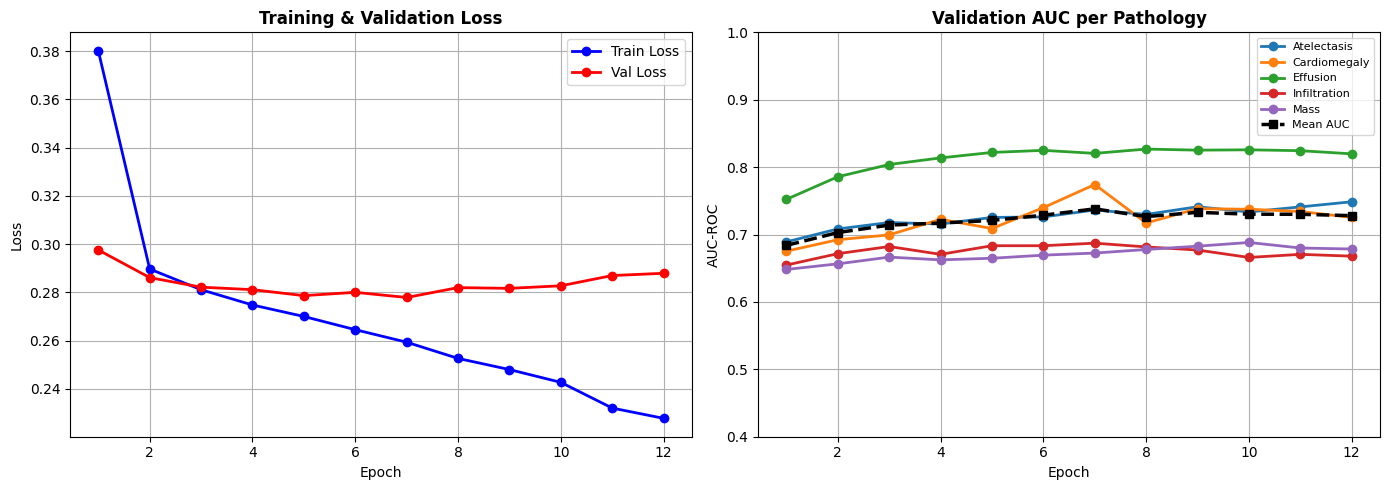

In [16]:
# --- 3.5 Plot Training Curves ---

def plot_training_curves(history: dict, pathologies: List[str]):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    epochs = range(1, len(history["train_loss"]) + 1)

    axes[0].plot(epochs, history["train_loss"], "b-o", label="Train Loss", lw=2)
    axes[0].plot(epochs, history["val_loss"], "r-o", label="Val Loss", lw=2)
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
    axes[0].set_title("Training & Validation Loss", fontweight="bold")
    axes[0].legend(); axes[0].grid(True)

    for pathology in pathologies:
        vals = [a[pathology] for a in history["val_aucs"]]
        axes[1].plot(epochs, vals, "-o", label=pathology, lw=2)
    mean_vals = [a["mean"] for a in history["val_aucs"]]
    axes[1].plot(epochs, mean_vals, "k--s", label="Mean AUC", lw=2.5)
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("AUC-ROC")
    axes[1].set_title("Validation AUC per Pathology", fontweight="bold")
    axes[1].legend(fontsize=8); axes[1].grid(True)
    axes[1].set_ylim([0.4, 1.0])

    plt.tight_layout()
    plt.show()


plot_training_curves(training_history, CFG.pathologies)

In [17]:
# ============================================================================
# SECTION 4 — EVALUATION
# ============================================================================

# --- 4.1 Full Evaluation ---

@torch.no_grad()
def full_evaluation(model, val_loader, pathologies, device):
    model.eval()
    all_labels, all_preds = [], []

    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_labels.append(labels.numpy())
        all_preds.append(probs)

    y_true = np.vstack(all_labels)
    y_pred = np.vstack(all_preds)

    print("=" * 55)
    print("EVALUATION RESULTS (REAL IMAGES)")
    print("=" * 55)

    aucs = compute_auc_scores(y_true, y_pred, pathologies)
    print(f"\n📊 AUC-ROC Scores:")
    for p, auc in aucs.items():
        marker = "⭐" if auc >= 0.8 else "✓" if auc >= 0.7 else "⚠️"
        print(f"   {marker} {p:20s}: {auc:.4f}")

    return y_true, y_pred, aucs


y_true, y_pred, eval_aucs = full_evaluation(model, val_loader, CFG.pathologies, DEVICE)

Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

EVALUATION RESULTS (REAL IMAGES)

📊 AUC-ROC Scores:
   ✓ Atelectasis         : 0.7362
   ✓ Cardiomegaly        : 0.7740
   ⭐ Effusion            : 0.8203
   ⚠️ Infiltration        : 0.6876
   ⚠️ Mass                : 0.6730
   ✓ mean                : 0.7382


In [18]:
# --- 4.2 Optimal Threshold Selection ---

def find_optimal_thresholds(y_true, y_pred, pathologies):
    thresholds = {}

    print("=" * 60)
    print("OPTIMAL THRESHOLD SEARCH")
    print("=" * 60)

    for i, p in enumerate(pathologies):
        precisions, recalls, thresh = precision_recall_curve(y_true[:, i], y_pred[:, i])
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_thresh = thresh[best_idx] if best_idx < len(thresh) else 0.5
        best_f1 = f1_scores[best_idx]
        thresholds[p] = round(float(best_thresh), 3)
        print(f"   {p:20s}: threshold = {best_thresh:.3f}  (F1 = {best_f1:.3f})")

    return thresholds


optimal_thresholds = find_optimal_thresholds(y_true, y_pred, CFG.pathologies)

OPTIMAL THRESHOLD SEARCH
   Atelectasis         : threshold = 0.249  (F1 = 0.329)
   Cardiomegaly        : threshold = 0.090  (F1 = 0.250)
   Effusion            : threshold = 0.284  (F1 = 0.483)
   Infiltration        : threshold = 0.240  (F1 = 0.435)
   Mass                : threshold = 0.116  (F1 = 0.222)


EVALUATION WITH OPTIMAL THRESHOLDS

📊 AUC-ROC Scores:
   ✓ Atelectasis         : 0.7362
   ✓ Cardiomegaly        : 0.7740
   ⭐ Effusion            : 0.8203
   ⚠️ Infiltration        : 0.6876
   ⚠️ Mass                : 0.6730
   ✓ mean                : 0.7382

📊 Classification Report (OPTIMAL thresholds):
   Pathology              Thresh   Prec    Rec     F1
   ----------------------------------------------------------
   Atelectasis            0.249    0.318   0.337   0.327  (+0.327)
   Cardiomegaly           0.090    0.400   0.138   0.205  (+0.205)
   Effusion               0.284    0.414   0.579   0.483  (+0.081)
   Infiltration           0.240    0.383   0.495   0.432  (+0.219)
   Mass                   0.116    0.188   0.268   0.221  (+0.221)

📊 Summary Comparison:
                           Fixed 0.5      Optimal
   ---------------------------------------------
   Atelectasis            F1=0.000      F1=0.327
   Cardiomegaly           F1=0.000      F1=0.205
   Effusion           

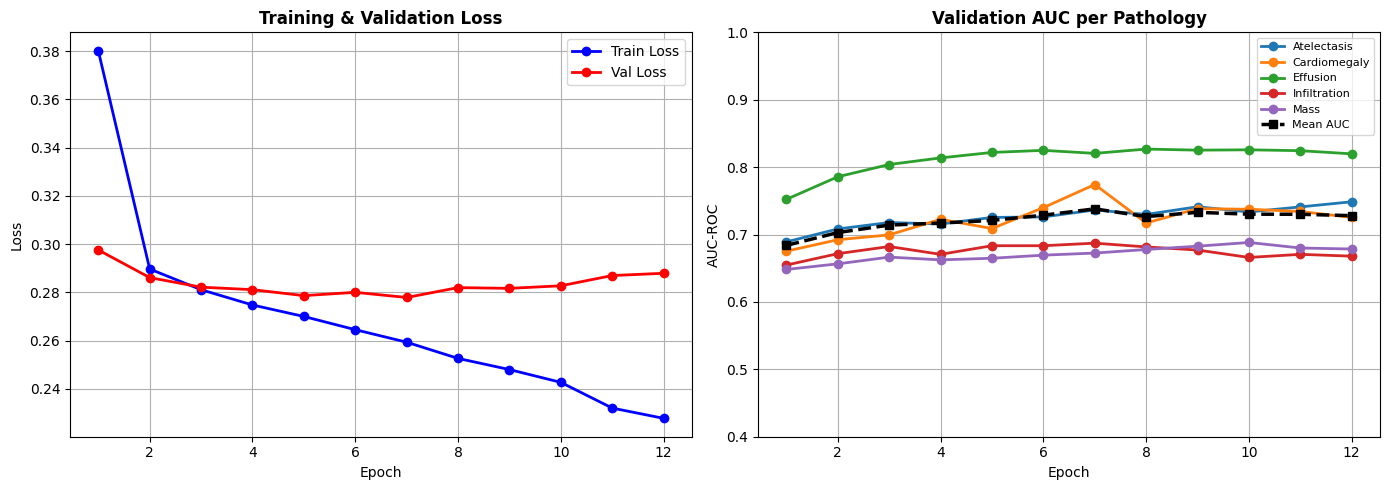

In [19]:
# --- 4.3 Evaluation with Optimal Thresholds ---

print("=" * 60)
print("EVALUATION WITH OPTIMAL THRESHOLDS")
print("=" * 60)

print(f"\n📊 AUC-ROC Scores:")
for p, auc in eval_aucs.items():
    marker = "⭐" if auc >= 0.8 else "✓" if auc >= 0.7 else "⚠️"
    print(f"   {marker} {p:20s}: {auc:.4f}")

print(f"\n📊 Classification Report (OPTIMAL thresholds):")
print(f"   {'Pathology':20s}   Thresh   Prec    Rec     F1")
print(f"   {'-' * 58}")

y_pred_opt = np.zeros_like(y_pred, dtype=int)
for i, p in enumerate(CFG.pathologies):
    t = optimal_thresholds[p]
    y_pred_opt[:, i] = (y_pred[:, i] >= t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true[:, i], y_pred_opt[:, i], average="binary", zero_division=0
    )
    old_f1 = precision_recall_fscore_support(
        y_true[:, i], (y_pred[:, i] >= 0.5).astype(int),
        average="binary", zero_division=0
    )[2]
    improvement = f"  (+{f1 - old_f1:.3f})" if f1 > old_f1 else ""
    print(f"   {p:20s}   {t:.3f}    {prec:.3f}   {rec:.3f}   {f1:.3f}{improvement}")

print(f"\n📊 Summary Comparison:")
print(f"   {'':20s}   {'Fixed 0.5':>10s}   {'Optimal':>10s}")
print(f"   {'-' * 45}")
for i, p in enumerate(CFG.pathologies):
    old_f1 = precision_recall_fscore_support(
        y_true[:, i], (y_pred[:, i] >= 0.5).astype(int),
        average="binary", zero_division=0
    )[2]
    new_f1 = precision_recall_fscore_support(
        y_true[:, i], y_pred_opt[:, i],
        average="binary", zero_division=0
    )[2]
    print(f"   {p:20s}   F1={old_f1:.3f}      F1={new_f1:.3f}")

plot_training_curves(training_history, CFG.pathologies)

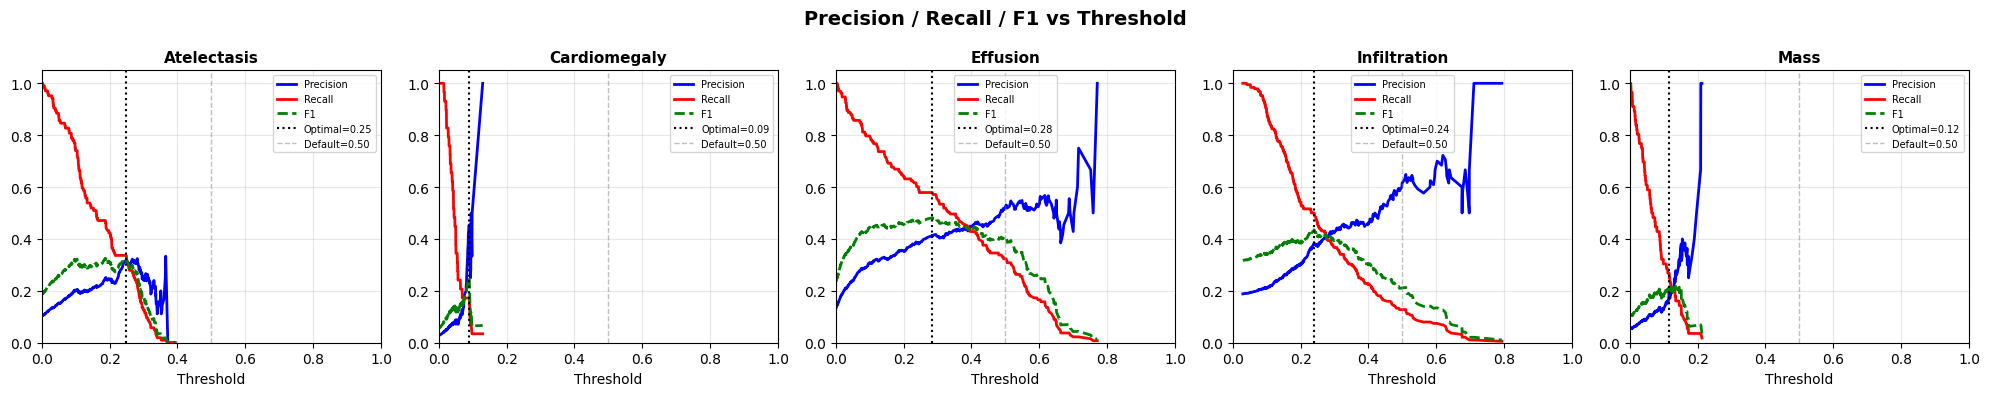

In [20]:
# --- 4.4 Precision-Recall-F1 vs Threshold ---

fig, axes = plt.subplots(1, len(CFG.pathologies), figsize=(4 * len(CFG.pathologies), 4))

for i, (p, ax) in enumerate(zip(CFG.pathologies, axes)):
    precisions, recalls, thresh = precision_recall_curve(y_true[:, i], y_pred[:, i])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    ax.plot(thresh, precisions[:-1], "b-", label="Precision", lw=2)
    ax.plot(thresh, recalls[:-1], "r-", label="Recall", lw=2)
    ax.plot(thresh, f1_scores[:-1], "g--", label="F1", lw=2)

    opt_t = optimal_thresholds[p]
    ax.axvline(x=opt_t, color="black", linestyle=":", lw=1.5, label=f"Optimal={opt_t:.2f}")
    ax.axvline(x=0.5, color="gray", linestyle="--", lw=1, alpha=0.5, label="Default=0.50")

    ax.set_title(p, fontsize=11, fontweight="bold")
    ax.set_xlabel("Threshold")
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1.05])
    ax.legend(fontsize=7); ax.grid(True, alpha=0.3)

plt.suptitle("Precision / Recall / F1 vs Threshold", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

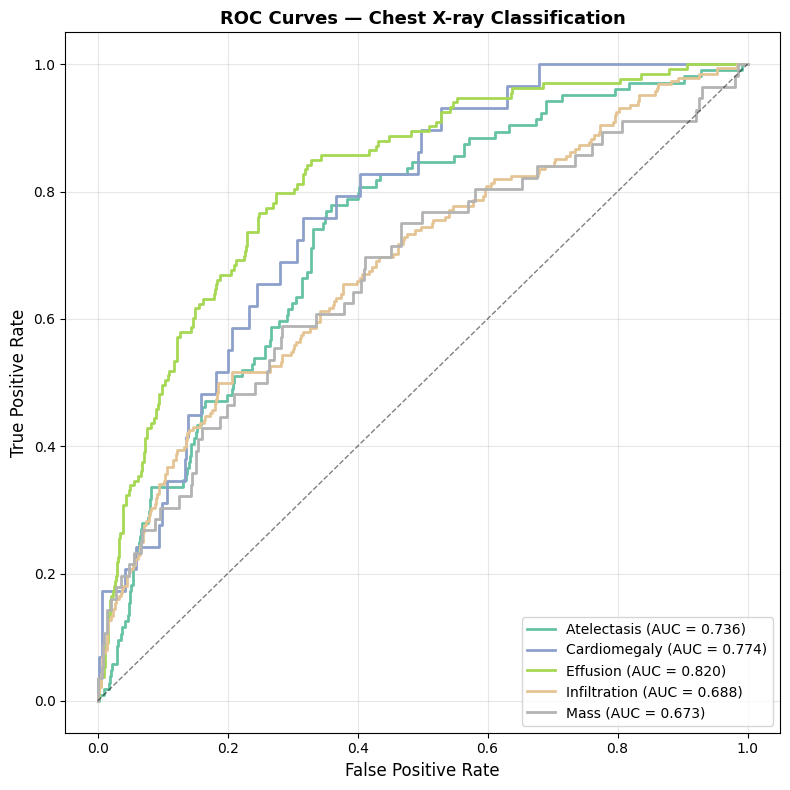

In [21]:
# --- 4.5 ROC Curves ---

def plot_roc_curves(y_true, y_pred, pathologies):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = plt.cm.Set2(np.linspace(0, 1, len(pathologies)))

    for i, (pathology, color) in enumerate(zip(pathologies, colors)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        ax.plot(fpr, tpr, color=color, lw=2, label=f"{pathology} (AUC = {auc:.3f})")

    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
    ax.set_xlabel("False Positive Rate", fontsize=12)
    ax.set_ylabel("True Positive Rate", fontsize=12)
    ax.set_title("ROC Curves — Chest X-ray Classification", fontsize=13, fontweight="bold")
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_roc_curves(y_true, y_pred, CFG.pathologies)

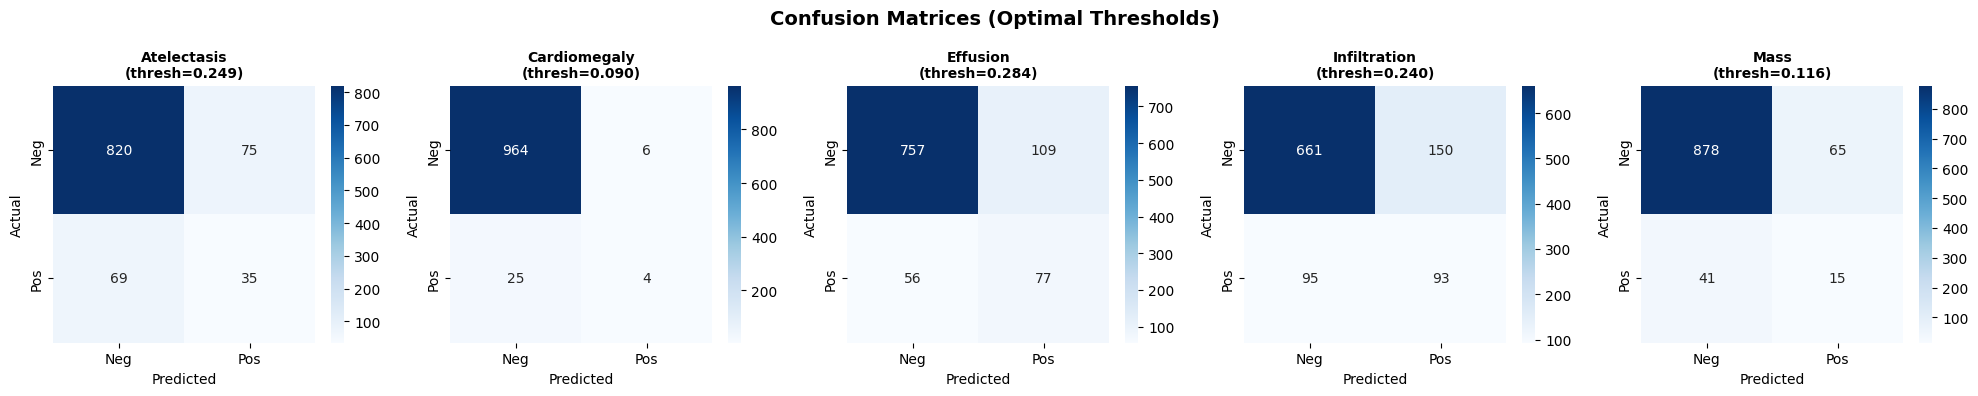

In [22]:
# --- 4.6 Confusion Matrices (Optimal Thresholds) ---

def plot_confusion_matrices(y_true, y_pred, pathologies, thresholds):
    n = len(pathologies)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    for i, (p, ax) in enumerate(zip(pathologies, axes)):
        t = thresholds[p]
        y_bin = (y_pred[:, i] >= t).astype(int)
        cm = confusion_matrix(y_true[:, i], y_bin)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                    xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
        ax.set_title(f"{p}\n(thresh={t:.3f})", fontsize=10, fontweight="bold")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.suptitle("Confusion Matrices (Optimal Thresholds)", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


plot_confusion_matrices(y_true, y_pred, CFG.pathologies, optimal_thresholds)

---
## Section 5: Grad-CAM Explainability

Grad-CAM highlights image regions most influential for each prediction,
providing visual explanations of model reasoning.

In [23]:
# ============================================================================
# SECTION 5 — GRAD-CAM EXPLAINABILITY (FINAL FIX)
# ============================================================================

def disable_inplace_relu(model):
    """Recursively disable inplace=True on all ReLU modules."""
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False


class GradCAM:
    """
    Hook-free Grad-CAM.
    Enables grad on the feature tensor directly instead of using hooks.
    """

    def __init__(self, model: nn.Module):
        self.model = model
        disable_inplace_relu(self.model)

    def generate(self, input_tensor: torch.Tensor, class_idx: int) -> np.ndarray:
        self.model.eval()
        x = input_tensor.clone().detach()

        # Step 1: Forward through feature extractor (no grad yet)
        with torch.enable_grad():
            features = self.model.backbone.features(x)

            # KEY FIX: Enable gradients on the features tensor itself
            features.retain_grad()

            # Step 2: ReLU + Global Average Pool + Flatten
            features_relu = torch.relu(features)
            pooled = torch.nn.functional.adaptive_avg_pool2d(features_relu, (1, 1))
            pooled = pooled.view(pooled.size(0), -1)

            # Step 3: Classifier
            output = self.model.backbone.classifier(pooled)

            # Step 4: Backward on target class
            self.model.zero_grad()
            target = output[0, class_idx]
            target.backward()

        # Step 5: Compute Grad-CAM
        gradients = features.grad.clone()
        activations = features.detach().clone()

        weights = gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        if cam.max() > 0:
            cam = cam / cam.max()

        cam = cv2.resize(cam, (CFG.image_size, CFG.image_size))
        return cam


print("✅ Grad-CAM ready.")

✅ Grad-CAM ready.


In [24]:
# --- 5.2 Visualization Helpers ---

def overlay_heatmap(image, heatmap, alpha=0.4):
    heatmap_color = cv2.applyColorMap(
        (heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET
    )
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0
    if image.max() > 1.0:
        image = image / 255.0
    overlay = alpha * heatmap_color + (1 - alpha) * image
    return np.clip(overlay, 0, 1)


def denormalize_tensor(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = (tensor.cpu() * std + mean).permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)


def visualize_gradcam(model, image_tensor, pathologies, top_k=3):
    model.eval()
    grad_cam = GradCAM(model)

    with torch.no_grad():
        logits = model(image_tensor.unsqueeze(0).to(DEVICE))
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    top_idx = np.argsort(probs)[::-1][:top_k]
    display_img = denormalize_tensor(image_tensor)

    fig, axes = plt.subplots(1, top_k + 1, figsize=(5 * (top_k + 1), 5))

    axes[0].imshow(display_img)
    axes[0].set_title("Original X-ray", fontsize=12, fontweight="bold")
    axes[0].axis("off")

    for ax_i, cls_i in enumerate(top_idx):
        heatmap = grad_cam.generate(
            image_tensor.unsqueeze(0).to(DEVICE), cls_i
        )
        overlay = overlay_heatmap(display_img, heatmap)
        axes[ax_i + 1].imshow(overlay)
        axes[ax_i + 1].set_title(
            f"{pathologies[cls_i]}\n(p = {probs[cls_i]:.3f})",
            fontsize=11, fontweight="bold",
        )
        axes[ax_i + 1].axis("off")

    plt.suptitle("Grad-CAM Explainability", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    return probs

GRAD-CAM ON POSITIVE SAMPLES

📷 Image: 00019967_017.png
   Ground truth: Atelectasis, Infiltration


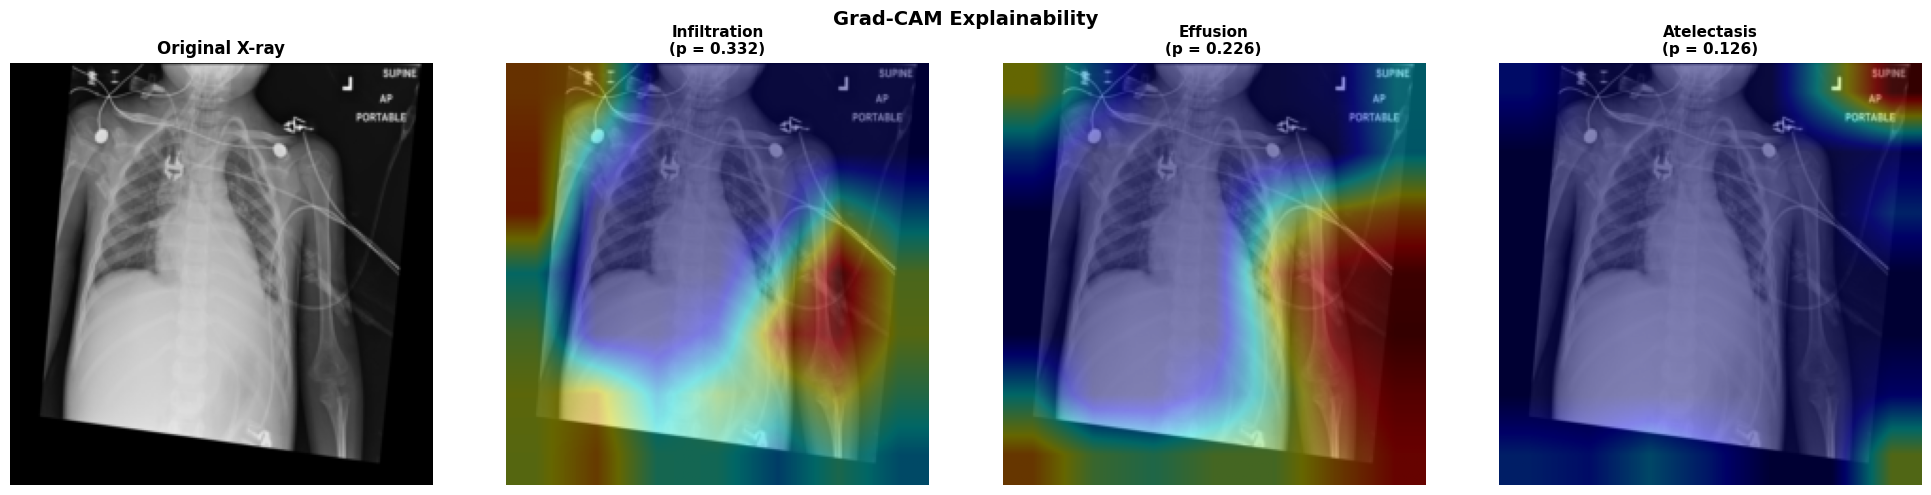

   CNN predictions:
     [✓] Atelectasis         : 0.126  (thresh=0.249) → neg
     [ ] Cardiomegaly        : 0.049  (thresh=0.090) → neg
     [ ] Effusion            : 0.226  (thresh=0.284) → neg
     [✓] Infiltration        : 0.332  (thresh=0.240) → POS
     [ ] Mass                : 0.077  (thresh=0.116) → neg

📷 Image: 00026167_009.png
   Ground truth: Effusion


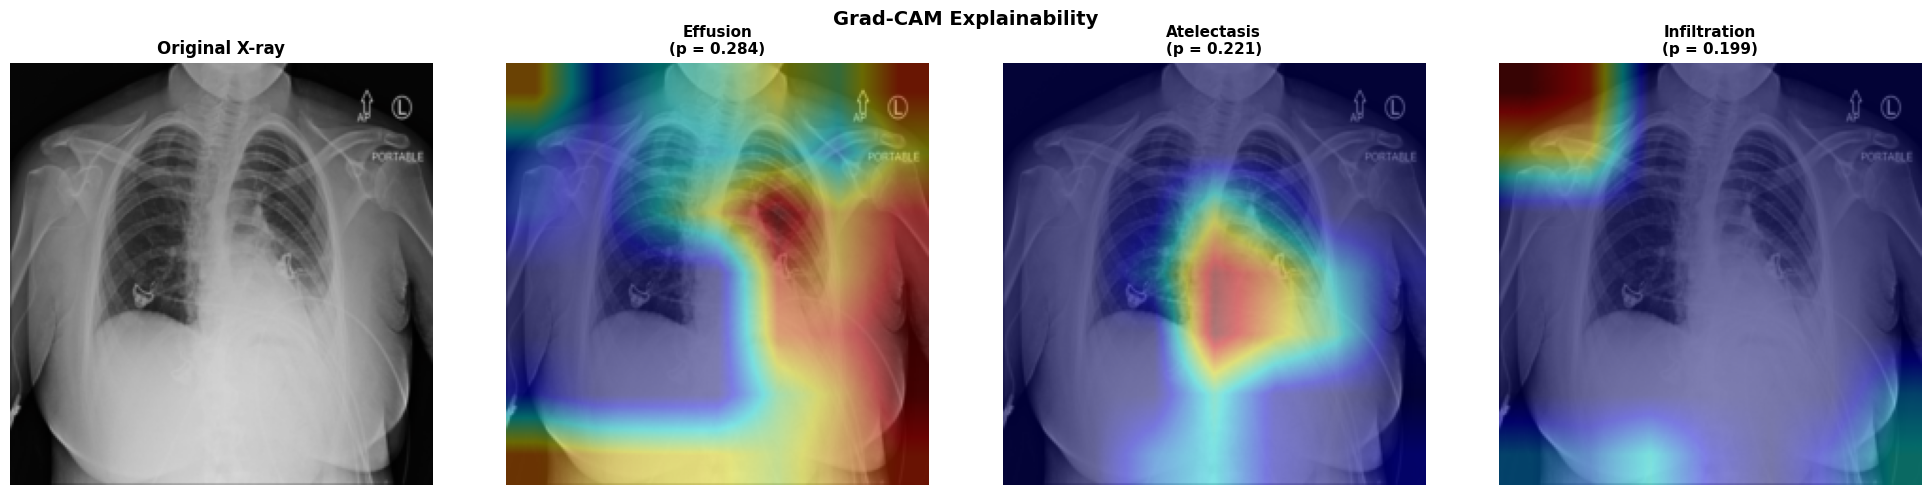

   CNN predictions:
     [ ] Atelectasis         : 0.221  (thresh=0.249) → neg
     [ ] Cardiomegaly        : 0.036  (thresh=0.090) → neg
     [✓] Effusion            : 0.284  (thresh=0.284) → POS
     [ ] Infiltration        : 0.199  (thresh=0.240) → neg
     [ ] Mass                : 0.070  (thresh=0.116) → neg

📷 Image: 00017267_001.png
   Ground truth: Atelectasis


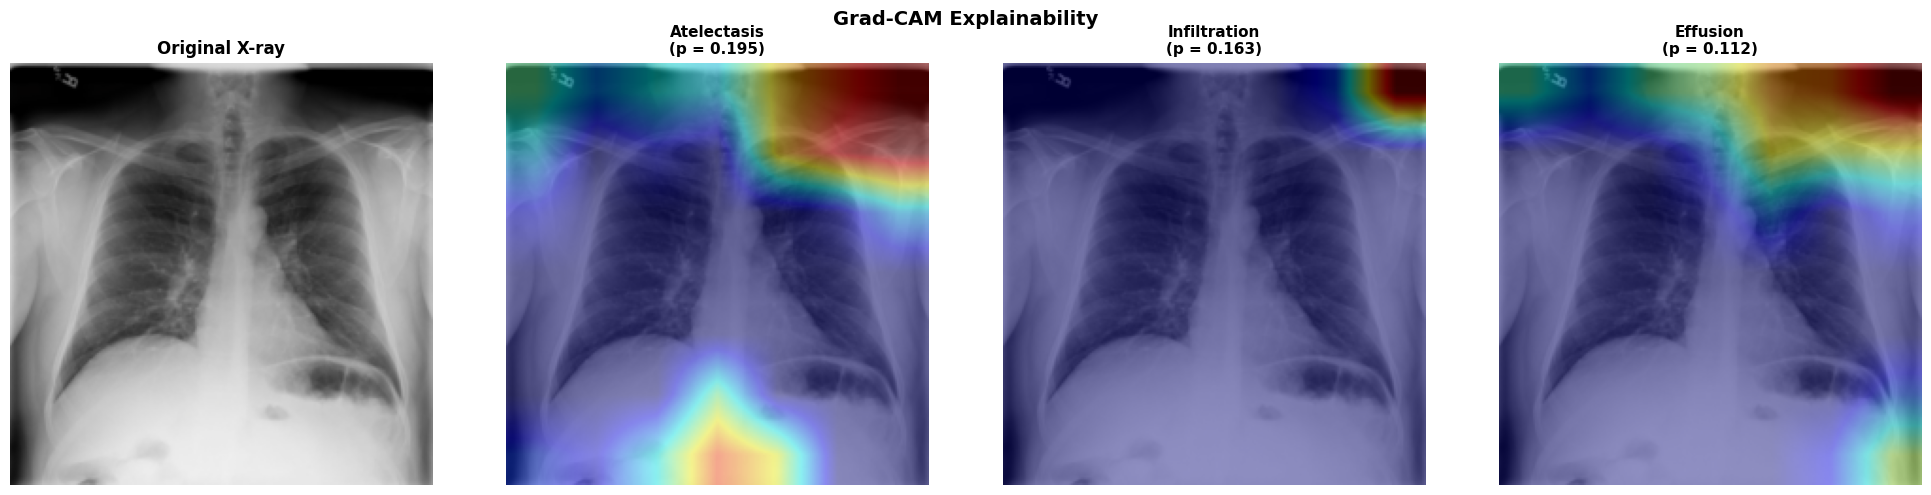

   CNN predictions:
     [✓] Atelectasis         : 0.195  (thresh=0.249) → neg
     [ ] Cardiomegaly        : 0.030  (thresh=0.090) → neg
     [ ] Effusion            : 0.112  (thresh=0.284) → neg
     [ ] Infiltration        : 0.163  (thresh=0.240) → neg
     [ ] Mass                : 0.055  (thresh=0.116) → neg

📷 Image: 00027213_017.png
   Ground truth: Infiltration


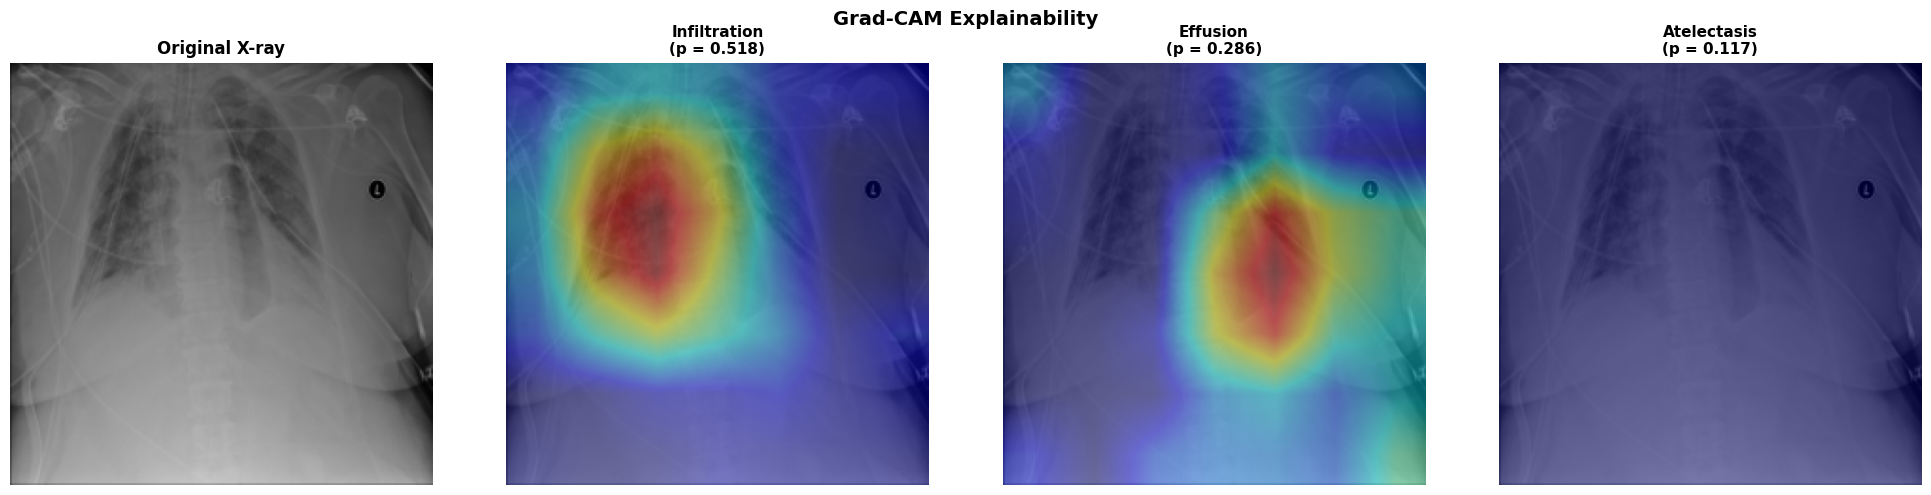

   CNN predictions:
     [ ] Atelectasis         : 0.117  (thresh=0.249) → neg
     [ ] Cardiomegaly        : 0.022  (thresh=0.090) → neg
     [ ] Effusion            : 0.286  (thresh=0.284) → POS
     [✓] Infiltration        : 0.518  (thresh=0.240) → POS
     [ ] Mass                : 0.042  (thresh=0.116) → neg

📷 Image: 00006271_066.png
   Ground truth: Infiltration


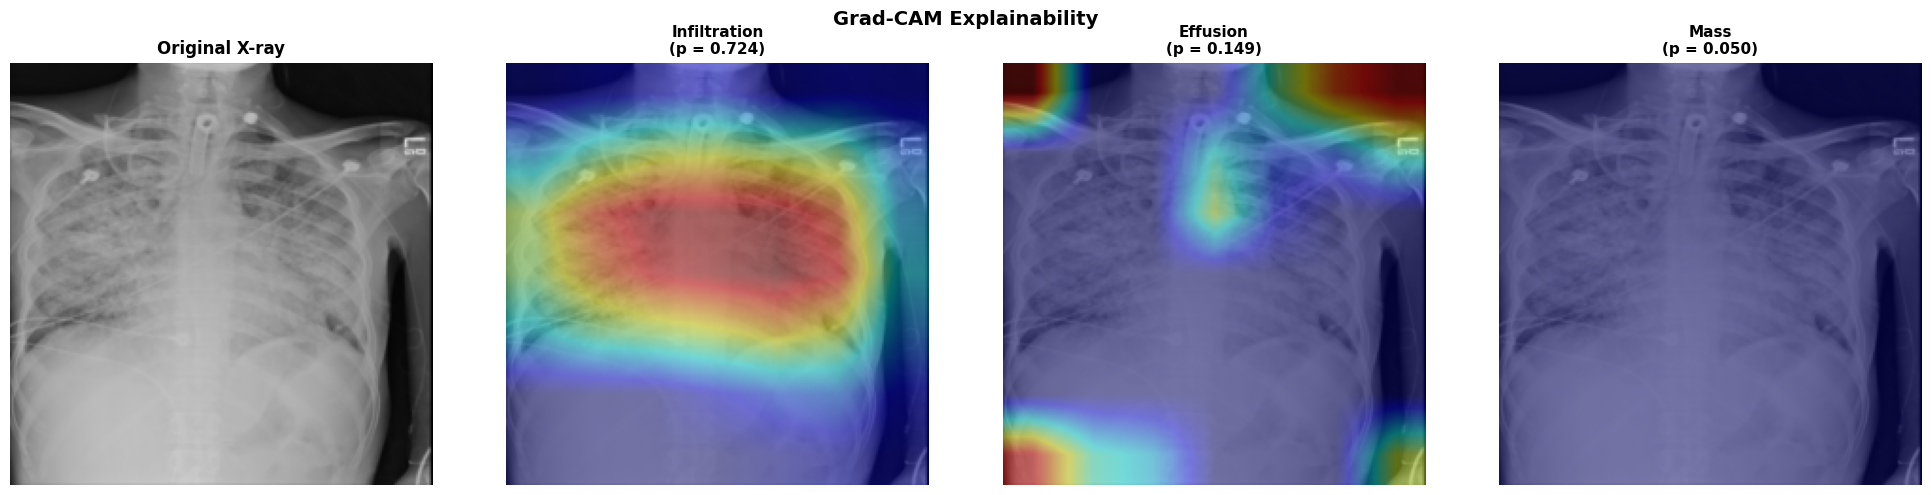

   CNN predictions:
     [ ] Atelectasis         : 0.032  (thresh=0.249) → neg
     [ ] Cardiomegaly        : 0.022  (thresh=0.090) → neg
     [ ] Effusion            : 0.149  (thresh=0.284) → neg
     [✓] Infiltration        : 0.724  (thresh=0.240) → POS
     [ ] Mass                : 0.050  (thresh=0.116) → neg


In [25]:
# --- 5.3 Grad-CAM Demo — Find samples WITH pathologies ---

def find_positive_samples(df, pathologies, n=5):
    """Find samples that have at least one positive pathology."""
    mask = df[list(pathologies)].sum(axis=1) > 0
    positives = df[mask]
    if len(positives) == 0:
        print("⚠️  No positive samples found!")
        return df.tail(n)
    return positives.sample(n=min(n, len(positives)), random_state=42)


# Find samples with actual pathologies
positive_df = find_positive_samples(df_labels_real, CFG.pathologies, n=5)

print("=" * 60)
print("GRAD-CAM ON POSITIVE SAMPLES")
print("=" * 60)

for idx in range(len(positive_df)):
    sample_ds = ChestXrayDataset(
        positive_df.iloc[[idx]].reset_index(drop=True),
        IMAGE_DIR, CFG.pathologies,
        transform=get_transforms(False),
        use_synthetic=False
    )
    sample_img, sample_lbl = sample_ds[0]

    # Show ground truth
    active = [p for i, p in enumerate(CFG.pathologies) if sample_lbl[i] > 0.5]
    img_name = positive_df.iloc[idx]["Image Index"]
    print(f"\n📷 Image: {img_name}")
    print(f"   Ground truth: {', '.join(active)}")

    # Generate Grad-CAM
    cnn_probs = visualize_gradcam(model, sample_img, CFG.pathologies)

    # Compare prediction vs ground truth
    print(f"   CNN predictions:")
    for i, p in enumerate(CFG.pathologies):
        gt = "✓" if sample_lbl[i] > 0.5 else " "
        t = optimal_thresholds[p]
        pred = "POS" if cnn_probs[i] >= t else "neg"
        print(f"     [{gt}] {p:20s}: {cnn_probs[i]:.3f}  (thresh={t:.3f}) → {pred}")

---
## Section 6: MedGemma Multimodal Reasoning (Inference Only)

**MedGemma 4B** provides clinical reasoning from image + symptoms.
Falls back to a comprehensive rule-based engine if unavailable.

In [26]:
# Get your token from: https://huggingface.co/settings/tokens
# You also need to accept the MedGemma license at:
# https://huggingface.co/google/medgemma-4b-it

import os
os.environ["HF_TOKEN"] = "YOUR_HF_TOKEN_HERE"  # ← Paste your token
print("✅ HF token set.")

✅ HF token set.


In [38]:
# ============================================================================
# SECTION 6 — MEDGEMMA MULTIMODAL REASONING
# ============================================================================

MEDGEMMA_SYSTEM_PROMPT = """You are a medical imaging AI assistant providing preliminary analysis.

STRICT RULES:
1. NEVER provide definitive diagnoses.
2. NEVER prescribe medications or treatments.
3. NEVER fabricate or hallucinate findings not visible in the image.
4. ONLY reason from visible radiographic evidence and provided symptoms.
5. Use hedging language: "suggests", "may indicate", "consistent with".
6. Always recommend professional medical evaluation.

OUTPUT FORMAT:
- OBSERVATIONS: What is visible in the image
- SYMPTOM CORRELATION: How symptoms relate to visual findings
- DIFFERENTIAL CONSIDERATIONS: Possible conditions ranked by likelihood
- REASONING: Step-by-step clinical reasoning
- RECOMMENDED FOLLOW-UP: Suggested next steps

DISCLAIMER: AI-generated preliminary analysis for research purposes only."""


class MedGemmaReasoner:
    def __init__(self, model_id: str = CFG.medgemma_model_id):
        self.model_id = model_id
        self.model = None
        self.processor = None
        self.available = False
        self.token = None
        self._get_token()

    def _get_token(self):
        import huggingface_hub
        self.token = os.environ.get("HF_TOKEN")
        if not self.token:
            try:
                self.token = huggingface_hub.get_token()
            except AttributeError:
                try:
                    self.token = huggingface_hub.HfFolder.get_token()
                except AttributeError:
                    self.token = None

        if self.token:
            print("✅ HuggingFace token found. MedGemma available on demand.")
            self.available = True
        else:
            print("⚠️  No HuggingFace token. Using rule-based fallback.")

    def _load_model(self):
        from transformers import AutoProcessor, AutoModelForImageTextToText

        print("⬇️  Loading MedGemma (freeing GPU first)...")

        global model
        model.cpu()
        torch.cuda.empty_cache()

        try:
            props = torch.cuda.get_device_properties(0)
            free = props.total_memory - torch.cuda.memory_allocated(0)
            print(f"   GPU memory available: {free / 1e9:.1f} GB")
        except Exception:
            print("   GPU memory check skipped.")

        self.processor = AutoProcessor.from_pretrained(self.model_id, token=self.token)
        self.model = AutoModelForImageTextToText.from_pretrained(
            self.model_id, token=self.token,
            torch_dtype=torch.bfloat16, device_map="auto",
            low_cpu_mem_usage=True,
        )
        print("✅ MedGemma loaded on GPU.")

    def _unload_model(self):
        global model
        print("🔄 Unloading MedGemma, restoring CNN to GPU...")
        if self.model is not None:
            del self.model
            self.model = None
        if self.processor is not None:
            del self.processor
            self.processor = None
        import gc
        gc.collect()
        torch.cuda.empty_cache()
        model.to(DEVICE)
        print(f"✅ CNN restored to {DEVICE}.")

    def reason(self, image, symptoms, cnn_predictions):
        if self.available and self.token:
            try:
                return self._medgemma_inference(image, symptoms, cnn_predictions)
            except Exception as e:
                print(f"⚠️  MedGemma inference failed: {e}")
                print("   → Falling back to rule-based reasoning.")
                try:
                    self._unload_model()
                except Exception:
                    global model
                    model.to(DEVICE)
                return self._fallback_reasoning(symptoms, cnn_predictions)
        return self._fallback_reasoning(symptoms, cnn_predictions)

    def _medgemma_inference(self, image, symptoms, cnn_predictions):
        if self.model is None:
            self._load_model()

        cnn_ctx = "\n".join(f"- {k}: {v:.1%}" for k, v in cnn_predictions.items())
        user_prompt = (
            f"{MEDGEMMA_SYSTEM_PROMPT}\n\n"
            f"Analyze this chest X-ray image.\n\n"
            f"Patient symptoms: {symptoms}\n\n"
            f"CNN pathology detection probabilities:\n{cnn_ctx}\n\n"
            f"Provide your structured clinical analysis."
        )

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": user_prompt},
                ],
            },
        ]

        inputs = self.processor.apply_chat_template(
            messages, add_generation_prompt=True,
            tokenize=True, return_dict=True, return_tensors="pt",
        ).to(self.model.device)

        with torch.no_grad():
            output = self.model.generate(
                **inputs, max_new_tokens=CFG.max_new_tokens,
                do_sample=False, temperature=1.0,
            )
        decoded = self.processor.decode(
            output[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True,
        )

        self._unload_model()
        return self._parse_output(decoded)

    def _parse_output(self, text):
        observations = self._extract(text, "OBSERVATIONS")
        symptom_corr = self._extract(text, "SYMPTOM CORRELATION")
        differential_raw = self._extract(text, "DIFFERENTIAL")
        followup = self._extract(text, "RECOMMENDED")

        diff_list = []
        for line in differential_raw.replace(". ", ".\n").split("\n"):
            line = line.strip().lstrip("-•*0123456789.) ")
            if line and len(line) > 3:
                diff_list.append(line)
        if not diff_list:
            diff_list = [differential_raw] if differential_raw else ["See full reasoning."]

        return {
            "raw_reasoning": str(text),
            "source": "medgemma",
            "observations": str(observations),
            "symptom_correlation": str(symptom_corr),
            "differential_considerations": diff_list,
            "recommended_followup": str(followup),
            "confidence": 0.75,
        }

    @staticmethod
    def _extract(text, header):
        lines = text.split("\n")
        capture = False
        buf = []
        for ln in lines:
            if header.upper() in ln.upper():
                capture = True
                continue
            if capture and ln.strip().startswith(("##", "**")) and header.upper() not in ln.upper():
                break
            if capture:
                buf.append(ln.strip())
        out = " ".join(buf).strip()
        return out if out else f"See full reasoning for {header.lower()} details."

    def _fallback_reasoning(self, symptoms, cnn_predictions):
        sym = symptoms.lower()
        active  = {k: v for k, v in cnn_predictions.items() if v > 0.3}
        hi_conf = {k: v for k, v in cnn_predictions.items() if v > 0.6}

        if active:
            parts = []
            for p, prob in sorted(active.items(), key=lambda x: -x[1]):
                sev = "prominent" if prob > 0.7 else "moderate" if prob > 0.5 else "subtle"
                parts.append(f"Radiographic features {sev}ly suggestive of "
                             f"{p.lower()} (CNN confidence: {prob:.1%})")
            observations = ". ".join(parts) + "."
        else:
            observations = "No significant pathological findings detected."

        sx_map = {
            "cough": ["Infiltration", "Atelectasis"],
            "fever": ["Infiltration"],
            "breath": ["Effusion", "Atelectasis"],
            "chest pain": ["Effusion", "Mass"],
            "weight loss": ["Mass"],
            "swelling": ["Cardiomegaly", "Effusion"],
            "fatigue": ["Cardiomegaly"],
            "wheezing": ["Atelectasis"],
        }
        correlations = []
        for kw, related in sx_map.items():
            if kw in sym:
                for p in related:
                    if p in active:
                        correlations.append(f"Reported '{kw}' is consistent with "
                                            f"detected {p.lower()} findings")
        sx_corr = ". ".join(correlations) + "." if correlations else \
            "Limited direct correlation. Clinical context recommended."

        diff_map = {
            "Infiltration": ["Pneumonia", "Pulmonary edema", "Alveolar hemorrhage"],
            "Effusion":     ["Pleural effusion", "CHF", "Malignancy"],
            "Cardiomegaly": ["Dilated cardiomyopathy", "Pericardial effusion", "Valvular disease"],
            "Mass":         ["Pulmonary nodule", "Lung carcinoma", "Granuloma"],
            "Atelectasis":  ["Mucus plugging", "Post-surgical atelectasis", "Endobronchial lesion"],
        }
        diffs = []
        for p in active:
            diffs.extend(diff_map.get(p, []))
        if not diffs:
            diffs = ["No acute pathology suggested"]

        fu = ["Clinical correlation recommended"]
        if hi_conf:
            fu.append("Consider CT chest for further characterization")
        if "Mass" in active:
            fu.append("Recommend CT with contrast and possible biopsy referral")
        if "Cardiomegaly" in active:
            fu.append("Echocardiography recommended")
        if "Effusion" in active:
            fu.append("Consider lateral decubitus view or ultrasound")

        return {
            "raw_reasoning": f"Automated analysis. Active findings: {list(active.keys())}",
            "source": "rule_based_fallback",
            "observations": str(observations),
            "symptom_correlation": str(sx_corr),
            "differential_considerations": diffs,
            "recommended_followup": str("; ".join(fu)),
            "confidence": min(0.85, 0.5 + 0.1 * len(correlations)),
        }


medgemma_reasoner = MedGemmaReasoner()

✅ HuggingFace token found. MedGemma available on demand.


In [28]:
# --- 6.2 MedGemma Reasoning Demo ---

positive_df = df_labels_real[df_labels_real[list(CFG.pathologies)].sum(axis=1) > 0]
demo_sample = positive_df.sample(1, random_state=42).reset_index(drop=True)

demo_ds = ChestXrayDataset(
    demo_sample,
    IMAGE_DIR, CFG.pathologies,
    transform=get_transforms(False),
    use_synthetic=False
)
demo_img_tensor, demo_lbl = demo_ds[0]

# Get CNN predictions — ensure model is on GPU
model.to(DEVICE)
model.eval()
with torch.no_grad():
    logits = model(demo_img_tensor.unsqueeze(0).to(DEVICE))
    cnn_probs = torch.sigmoid(logits).cpu().numpy()[0]

demo_cnn_preds = {p: float(cnn_probs[i]) for i, p in enumerate(CFG.pathologies)}

# Convert tensor to PIL
demo_pil = transforms.ToPILImage()(
    (demo_img_tensor.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
     + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)).clamp(0, 1)
)

# Ground truth
active_gt = [p for i, p in enumerate(CFG.pathologies) if demo_lbl[i] > 0.5]
print(f"📷 Image: {demo_sample.iloc[0]['Image Index']}")
print(f"   Ground truth: {', '.join(active_gt)}")

# Run reasoning — saved as reasoning_output
demo_symptoms = (
    "Patient presents with persistent cough, low-grade fever, "
    "and shortness of breath for 5 days."
)

reasoning_output = medgemma_reasoner.reason(demo_pil, demo_symptoms, demo_cnn_preds)

print("\n" + "=" * 60)
print("CLINICAL REASONING OUTPUT")
print(f"Source: {reasoning_output.get('source', 'unknown')}")
print("=" * 60)

print(f"\n📌 OBSERVATIONS:")
print(f"   {reasoning_output.get('observations', 'N/A')}")

print(f"\n📌 SYMPTOM CORRELATION:")
print(f"   {reasoning_output.get('symptom_correlation', 'N/A')}")

print(f"\n📌 DIFFERENTIAL CONSIDERATIONS:")
diff = reasoning_output.get('differential_considerations', [])
if isinstance(diff, list):
    for item in diff:
        print(f"   • {item}")
else:
    print(f"   {diff}")

print(f"\n📌 RECOMMENDED FOLLOW-UP:")
print(f"   {reasoning_output.get('recommended_followup', 'N/A')}")

print(f"\n📌 CONFIDENCE: {reasoning_output.get('confidence', 'N/A')}")

📷 Image: 00019967_017.png
   Ground truth: Atelectasis, Infiltration
⬇️  Loading MedGemma (freeing GPU first)...
⚠️  MedGemma inference failed: 'torch._C._CudaDeviceProperties' object has no attribute 'total_mem'
   → Falling back to rule-based reasoning.
🔄 Unloading MedGemma, restoring CNN to GPU...
✅ CNN restored to cuda.

CLINICAL REASONING OUTPUT
Source: rule_based_fallback

📌 OBSERVATIONS:
   Radiographic features subtlely suggestive of infiltration (CNN confidence: 33.2%).

📌 SYMPTOM CORRELATION:
   Reported 'cough' is consistent with detected infiltration findings. Reported 'fever' is consistent with detected infiltration findings.

📌 DIFFERENTIAL CONSIDERATIONS:
   • Pneumonia
   • Pulmonary edema
   • Alveolar hemorrhage

📌 RECOMMENDED FOLLOW-UP:
   Clinical correlation recommended

📌 CONFIDENCE: 0.7


---
## Section 7: Fusion Module

Merges CNN pathology probabilities with clinical reasoning output.
Detects contradictions and adjusts confidence accordingly.

In [29]:
# ============================================================================
# SECTION 7 — FUSION MODULE
# ============================================================================

# Fix: pick up whichever variable name was used in Cell 33
try:
    reasoning_output = reasoning_output
except NameError:
    try:
        reasoning_output = raw_reasoning_output
    except NameError:
        print("⚠️  No reasoning output found. Re-run Cell 33 first.")

class FusionModule:
    CNN_WEIGHT = 0.6
    LLM_WEIGHT = 0.4
    CONTRADICTION_PENALTY = 0.25

    def __init__(self, pathologies):
        self.pathologies = pathologies

    def fuse(self, cnn_predictions, reasoning_out):
        raw = reasoning_out.get("raw_reasoning", "") if isinstance(reasoning_out, dict) else ""
        obs = reasoning_out.get("observations", "") if isinstance(reasoning_out, dict) else ""
        diff = reasoning_out.get("differential_considerations", []) if isinstance(reasoning_out, dict) else []

        text = str(raw) + " " + str(obs)
        if isinstance(diff, list):
            text += " " + " ".join(str(d) for d in diff)
        elif isinstance(diff, str):
            text += " " + diff
        text = text.lower()

        llm_mentioned = {p: p.lower() in text for p in self.pathologies}
        fused_scores = {}
        contradictions = []
        agree_count = 0

        for p in self.pathologies:
            cnn_p = float(cnn_predictions.get(p, 0.0))
            cnn_pos = cnn_p > 0.5
            llm_pos = llm_mentioned[p]

            if cnn_pos == llm_pos:
                agree_count += 1
                fused = min(0.99, cnn_p * 1.1) if cnn_pos else cnn_p * 0.95
            else:
                contradictions.append({
                    "pathology": str(p),
                    "cnn_says": "positive" if cnn_pos else "negative",
                    "llm_says": "mentioned" if llm_pos else "not mentioned",
                    "cnn_probability": round(float(cnn_p), 3),
                })
                fused = cnn_p * (1 - self.CONTRADICTION_PENALTY)

            fused_scores[p] = round(float(fused), 4)

        agreement_ratio = agree_count / len(self.pathologies)
        llm_conf = float(reasoning_out.get("confidence", 0.5)) if isinstance(reasoning_out, dict) else 0.5
        overall = (
            self.CNN_WEIGHT * np.mean(list(cnn_predictions.values()))
            + self.LLM_WEIGHT * llm_conf
        ) * (0.7 + 0.3 * agreement_ratio)

        return {
            "fused_pathology_scores": fused_scores,
            "contradictions": contradictions,
            "agreement_ratio": round(float(agreement_ratio), 3),
            "overall_confidence": round(float(overall), 4),
            "num_contradictions": len(contradictions),
            "cnn_weight": self.CNN_WEIGHT,
            "llm_weight": self.LLM_WEIGHT,
        }


fusion_module = FusionModule(CFG.pathologies)
fusion_result = fusion_module.fuse(demo_cnn_preds, reasoning_output)

print("=" * 60)
print("FUSION RESULTS")
print("=" * 60)
print("\n📊 Fused Pathology Scores:")
for p, s in fusion_result["fused_pathology_scores"].items():
    bar = "█" * int(s * 30)
    print(f"   {p:20s}: {s:.4f}  {bar}")
print(f"\n🔗 Agreement Ratio   : {fusion_result['agreement_ratio']:.1%}")
print(f"⚡ Overall Confidence : {fusion_result['overall_confidence']:.4f}")
if fusion_result["contradictions"]:
    print(f"\n⚠️  Contradictions ({fusion_result['num_contradictions']}):")
    for c in fusion_result["contradictions"]:
        print(f"   • {c['pathology']}: CNN={c['cnn_says']}, LLM={c['llm_says']} "
              f"(p={c['cnn_probability']})")

FUSION RESULTS

📊 Fused Pathology Scores:
   Atelectasis         : 0.1196  ███
   Cardiomegaly        : 0.0468  █
   Effusion            : 0.2144  ██████
   Infiltration        : 0.2493  ███████
   Mass                : 0.0732  ██

🔗 Agreement Ratio   : 80.0%
⚡ Overall Confidence : 0.3546

⚠️  Contradictions (1):
   • Infiltration: CNN=negative, LLM=mentioned (p=0.332)


---
## Section 8: Uncertainty Estimation

Combines CNN entropy, LLM confidence, and fusion agreement
into a calibrated overall confidence metric.

In [30]:
# ============================================================================
# SECTION 8 — UNCERTAINTY ESTIMATION
# ============================================================================

class UncertaintyEstimator:
    @staticmethod
    def sigmoid_entropy(probs):
        eps = 1e-7
        p = np.clip(probs, eps, 1 - eps)
        entropy = -(p * np.log2(p) + (1 - p) * np.log2(1 - p))
        return float(np.mean(entropy))

    @staticmethod
    def compute_cnn_confidence(probs):
        entropy = UncertaintyEstimator.sigmoid_entropy(probs)
        return round(float(1.0 - entropy), 4)

    @staticmethod
    def estimate(cnn_probs_array, fusion_res, reasoning_out):
        cnn_conf = UncertaintyEstimator.compute_cnn_confidence(cnn_probs_array)

        llm_conf = 0.5
        agreement = 0.5
        n_contradictions = 0

        if isinstance(reasoning_out, dict):
            llm_conf = float(reasoning_out.get("confidence", 0.5))
        if isinstance(fusion_res, dict):
            agreement = float(fusion_res.get("agreement_ratio", 0.5))
            n_contradictions = int(fusion_res.get("num_contradictions", 0))

        combined = 0.4 * cnn_conf + 0.3 * llm_conf + 0.3 * agreement
        penalty = n_contradictions * 0.05
        final_conf = max(0.1, min(0.99, combined - penalty))

        if final_conf >= 0.75:
            level = "HIGH"
        elif final_conf >= 0.5:
            level = "MODERATE"
        else:
            level = "LOW"

        return {
            "cnn_confidence": cnn_conf,
            "llm_confidence": round(llm_conf, 4),
            "agreement_ratio": round(agreement, 4),
            "combined_confidence": round(combined, 4),
            "contradiction_penalty": round(penalty, 4),
            "final_confidence": round(final_conf, 4),
            "confidence_level": level,
            "interpretation": {
                "HIGH": "Strong agreement between modalities. Findings are reliable.",
                "MODERATE": "Partial agreement. Findings should be verified clinically.",
                "LOW": "Significant disagreement or uncertainty. Professional review essential.",
            }[level],
        }


uncertainty = UncertaintyEstimator.estimate(cnn_probs, fusion_result, reasoning_output)

print("=" * 60)
print("UNCERTAINTY ESTIMATION")
print("=" * 60)
for k, v in uncertainty.items():
    print(f"   {k:30s}: {v}")

UNCERTAINTY ESTIMATION
   cnn_confidence                : 0.4183
   llm_confidence                : 0.7
   agreement_ratio               : 0.8
   combined_confidence           : 0.6173
   contradiction_penalty         : 0.05
   final_confidence              : 0.5673
   confidence_level              : MODERATE
   interpretation                : Partial agreement. Findings should be verified clinically.


---
## Section 9: Risk Stratification & Final Report

Combines all modules into a single structured JSON output.

In [31]:
# ============================================================================
# SECTION 9 — RISK STRATIFICATION & STRUCTURED OUTPUT
# ============================================================================

def risk_stratify(fused_scores, uncertainty_result):
    max_score = max(fused_scores.values())
    conf_level = uncertainty_result["confidence_level"]

    if max_score > 0.7 and conf_level == "HIGH":
        risk = "HIGH"
        action = "Urgent radiologist review recommended within 24 hours."
    elif max_score > 0.5 or conf_level == "MODERATE":
        risk = "MODERATE"
        action = "Schedule follow-up imaging and clinical correlation."
    else:
        risk = "LOW"
        action = "Routine follow-up. No immediate action required."

    return {"risk_level": risk, "recommended_action": action}


def generate_final_report(
    cnn_preds, reasoning_out, fusion_res,
    uncertainty_res, pathologies, opt_thresholds
):
    risk = risk_stratify(
        fusion_res["fused_pathology_scores"], uncertainty_res
    )

    thresholded = {}
    for p in pathologies:
        prob = float(cnn_preds[p])
        thresh = float(opt_thresholds[p])
        thresholded[p] = {
            "probability": round(prob, 4),
            "threshold": thresh,
            "prediction": "POSITIVE" if prob >= thresh else "NEGATIVE",
        }

    obs = ""
    sx_corr = ""
    diff = []
    fu = ""
    source = "unknown"

    if isinstance(reasoning_out, dict):
        obs = str(reasoning_out.get("observations", ""))
        sx_corr = str(reasoning_out.get("symptom_correlation", ""))
        raw_diff = reasoning_out.get("differential_considerations", [])
        if isinstance(raw_diff, list):
            diff = [str(d) for d in raw_diff]
        else:
            diff = [str(raw_diff)]
        fu = str(reasoning_out.get("recommended_followup", ""))
        source = str(reasoning_out.get("source", "unknown"))

    return {
        "report_metadata": {
            "system": "Multimodal Clinical AI Assistant",
            "version": "1.0",
            "disclaimer": CFG.disclaimer,
            "reasoning_source": source,
        },
        "cnn_predictions_raw": {p: round(float(cnn_preds[p]), 4) for p in pathologies},
        "cnn_predictions_thresholded": thresholded,
        "clinical_reasoning": {
            "observations": obs,
            "symptom_correlation": sx_corr,
            "differential_considerations": diff,
            "recommended_followup": fu,
        },
        "fusion_results": fusion_res,
        "uncertainty": uncertainty_res,
        "risk_stratification": risk,
    }


report = generate_final_report(
    demo_cnn_preds, reasoning_output, fusion_result,
    uncertainty, CFG.pathologies, optimal_thresholds
)

print("=" * 60)
print("FINAL STRUCTURED REPORT (JSON)")
print("=" * 60)
print(json.dumps(report, indent=2, default=str))

FINAL STRUCTURED REPORT (JSON)
{
  "report_metadata": {
    "system": "Multimodal Clinical AI Assistant",
    "version": "1.0",
    "disclaimer": "AI-generated preliminary analysis for research purposes only. Not a substitute for professional medical evaluation.",
    "reasoning_source": "rule_based_fallback"
  },
  "cnn_predictions_raw": {
    "Atelectasis": 0.1259,
    "Cardiomegaly": 0.0493,
    "Effusion": 0.2257,
    "Infiltration": 0.3324,
    "Mass": 0.077
  },
  "cnn_predictions_thresholded": {
    "Atelectasis": {
      "probability": 0.1259,
      "threshold": 0.249,
      "prediction": "NEGATIVE"
    },
    "Cardiomegaly": {
      "probability": 0.0493,
      "threshold": 0.09,
      "prediction": "NEGATIVE"
    },
    "Effusion": {
      "probability": 0.2257,
      "threshold": 0.284,
      "prediction": "NEGATIVE"
    },
    "Infiltration": {
      "probability": 0.3324,
      "threshold": 0.24,
      "prediction": "POSITIVE"
    },
    "Mass": {
      "probability": 0.07

In [32]:
# --- 9.2 Report Summary ---

print("=" * 60)
print("📋 CLINICAL AI REPORT SUMMARY")
print("=" * 60)

print(f"\n🏥 RISK LEVEL: {report['risk_stratification']['risk_level']}")
print(f"📋 ACTION    : {report['risk_stratification']['recommended_action']}")
print(f"🔒 CONFIDENCE: {report['uncertainty']['final_confidence']:.1%} "
      f"({report['uncertainty']['confidence_level']})")

print(f"\n📊 CNN Pathology Predictions (with optimal thresholds):")
print(f"   {'Pathology':20s}  {'Prob':>6s}  {'Thresh':>6s}  {'Result':>10s}")
print(f"   {'-' * 50}")
for p, info in report["cnn_predictions_thresholded"].items():
    marker = "🔴" if info["prediction"] == "POSITIVE" else "🟢"
    print(f"   {marker} {p:18s}  {info['probability']:.4f}  {info['threshold']:.3f}  "
          f"{info['prediction']}")

print(f"\n📌 OBSERVATIONS:")
print(f"   {report['clinical_reasoning']['observations'][:300]}")

print(f"\n📌 SYMPTOM CORRELATION:")
print(f"   {report['clinical_reasoning']['symptom_correlation'][:300]}")

print(f"\n📌 DIFFERENTIAL CONSIDERATIONS:")
for d in report['clinical_reasoning']['differential_considerations']:
    print(f"   • {d}")

print(f"\n📌 RECOMMENDED FOLLOW-UP:")
print(f"   {report['clinical_reasoning']['recommended_followup'][:300]}")

print(f"\n🔗 Fusion Agreement: {report['fusion_results']['agreement_ratio']:.1%}")
if report['fusion_results']['contradictions']:
    print(f"⚠️  Contradictions:")
    for c in report['fusion_results']['contradictions']:
        print(f"   • {c['pathology']}: CNN={c['cnn_says']}, LLM={c['llm_says']}")

print(f"\n{'=' * 60}")
print(f"⚠️  {CFG.disclaimer}")
print(f"{'=' * 60}")

📋 CLINICAL AI REPORT SUMMARY

🏥 RISK LEVEL: MODERATE
📋 ACTION    : Schedule follow-up imaging and clinical correlation.
🔒 CONFIDENCE: 56.7% (MODERATE)

📊 CNN Pathology Predictions (with optimal thresholds):
   Pathology               Prob  Thresh      Result
   --------------------------------------------------
   🟢 Atelectasis         0.1259  0.249  NEGATIVE
   🟢 Cardiomegaly        0.0493  0.090  NEGATIVE
   🟢 Effusion            0.2257  0.284  NEGATIVE
   🔴 Infiltration        0.3324  0.240  POSITIVE
   🟢 Mass                0.0770  0.116  NEGATIVE

📌 OBSERVATIONS:
   Radiographic features subtlely suggestive of infiltration (CNN confidence: 33.2%).

📌 SYMPTOM CORRELATION:
   Reported 'cough' is consistent with detected infiltration findings. Reported 'fever' is consistent with detected infiltration findings.

📌 DIFFERENTIAL CONSIDERATIONS:
   • Pneumonia
   • Pulmonary edema
   • Alveolar hemorrhage

📌 RECOMMENDED FOLLOW-UP:
   Clinical correlation recommended

🔗 Fusion Agreement: 

---
## Section 10: End-to-End Pipeline Demo

Complete pipeline on multiple images:
Image → CNN → Grad-CAM → Reasoning → Fusion → Uncertainty → Report

In [33]:
# ============================================================================
# SECTION 10 — END-TO-END PIPELINE
# ============================================================================

def run_full_pipeline(
    cnn_model, image_tensor, label_tensor, image_name,
    symptoms, pathologies, opt_thresholds,
    reasoner, fuser
):
    print("\n" + "=" * 60)
    print(f"🏥 FULL PIPELINE — {image_name}")
    print("=" * 60)

    # Step 1: Ground truth
    active_gt = [p for i, p in enumerate(pathologies) if label_tensor[i] > 0.5]
    print(f"\n1️⃣  Ground Truth: {', '.join(active_gt) if active_gt else 'No Finding'}")

    # Step 2: CNN — ensure on GPU
    cnn_model.to(DEVICE)
    cnn_model.eval()
    with torch.no_grad():
        logits = cnn_model(image_tensor.unsqueeze(0).to(DEVICE))
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    cnn_preds = {p: float(probs[i]) for i, p in enumerate(pathologies)}

    print(f"\n2️⃣  CNN Predictions:")
    for p, prob in cnn_preds.items():
        t = opt_thresholds[p]
        status = "🔴 POS" if prob >= t else "🟢 neg"
        print(f"     {p:20s}: {prob:.4f} (thresh={t:.3f}) {status}")

    # Step 3: Grad-CAM
    print(f"\n3️⃣  Grad-CAM Visualization:")
    visualize_gradcam(cnn_model, image_tensor, pathologies)

    # Step 4: Reasoning (may swap GPU for MedGemma)
    pil_img = transforms.ToPILImage()(
        (image_tensor.cpu() * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
         + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)).clamp(0, 1)
    )
    reasoning = reasoner.reason(pil_img, symptoms, cnn_preds)

    print(f"\n4️⃣  Clinical Reasoning ({reasoning.get('source', 'unknown')}):")
    print(f"     Observations: {str(reasoning.get('observations', 'N/A'))[:200]}...")

    diff = reasoning.get('differential_considerations', [])
    print(f"     Differentials:")
    if isinstance(diff, list):
        for d in diff[:5]:
            print(f"       • {d}")
    else:
        print(f"       {diff}")

    # Step 5: Fusion
    fusion = fuser.fuse(cnn_preds, reasoning)
    print(f"\n5️⃣  Fusion:")
    print(f"     Agreement: {fusion['agreement_ratio']:.1%}")
    print(f"     Contradictions: {fusion['num_contradictions']}")

    # Step 6: Uncertainty
    unc = UncertaintyEstimator.estimate(probs, fusion, reasoning)
    print(f"\n6️⃣  Uncertainty: {unc['final_confidence']:.1%} ({unc['confidence_level']})")
    print(f"     {unc['interpretation']}")

    # Step 7: Report
    full_report = generate_final_report(
        cnn_preds, reasoning, fusion, unc, pathologies, opt_thresholds
    )
    risk = full_report["risk_stratification"]
    print(f"\n7️⃣  Risk: {risk['risk_level']} — {risk['recommended_action']}")

    print(f"\n⚠️  {CFG.disclaimer}")
    return full_report


🏥 FULL PIPELINE — 00004006_026.png

1️⃣  Ground Truth: Atelectasis

2️⃣  CNN Predictions:
     Atelectasis         : 0.2340 (thresh=0.249) 🟢 neg
     Cardiomegaly        : 0.0473 (thresh=0.090) 🟢 neg
     Effusion            : 0.1561 (thresh=0.284) 🟢 neg
     Infiltration        : 0.1964 (thresh=0.240) 🟢 neg
     Mass                : 0.0673 (thresh=0.116) 🟢 neg

3️⃣  Grad-CAM Visualization:


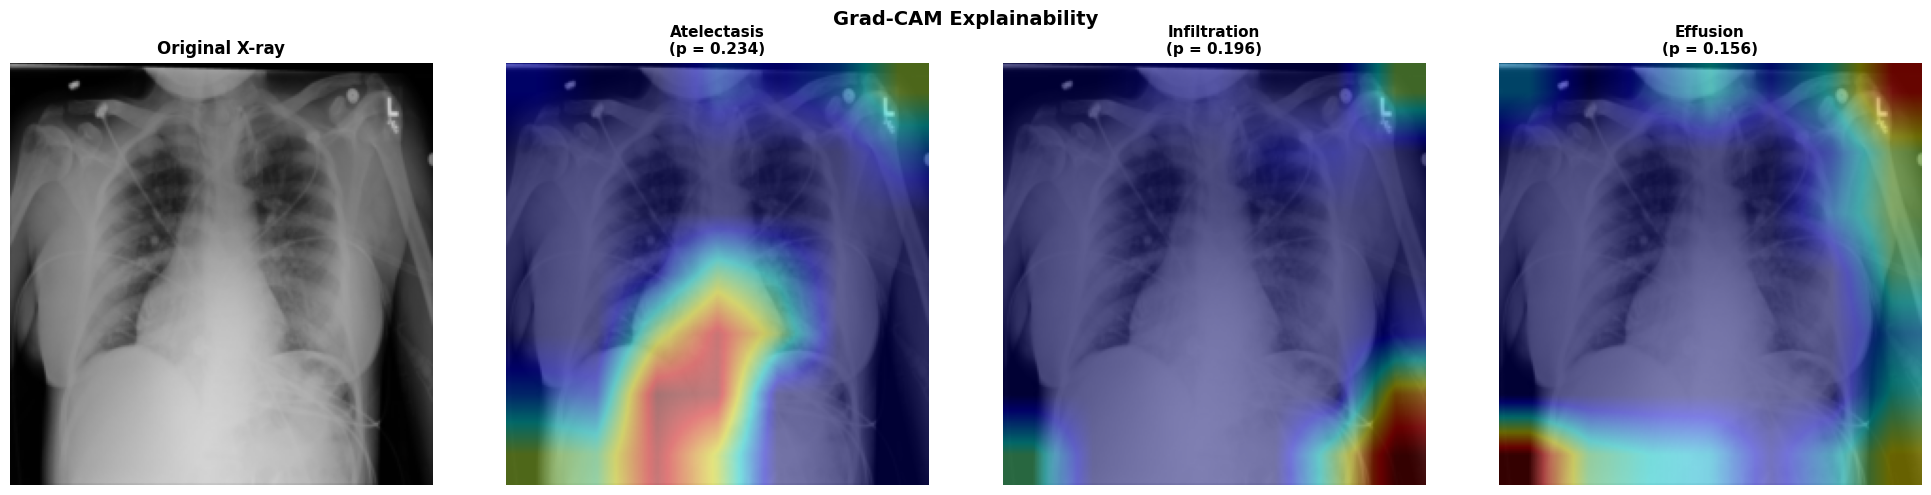

⬇️  Loading MedGemma (freeing GPU first)...
⚠️  MedGemma inference failed: 'torch._C._CudaDeviceProperties' object has no attribute 'total_mem'
   → Falling back to rule-based reasoning.
🔄 Unloading MedGemma, restoring CNN to GPU...
✅ CNN restored to cuda.

4️⃣  Clinical Reasoning (rule_based_fallback):
     Observations: No significant pathological findings detected....
     Differentials:
       • No acute pathology suggested

5️⃣  Fusion:
     Agreement: 100.0%
     Contradictions: 0

6️⃣  Uncertainty: 63.0% (MODERATE)
     Partial agreement. Findings should be verified clinically.

7️⃣  Risk: MODERATE — Schedule follow-up imaging and clinical correlation.

⚠️  AI-generated preliminary analysis for research purposes only. Not a substitute for professional medical evaluation.

🏥 FULL PIPELINE — 00011752_016.png

1️⃣  Ground Truth: Effusion

2️⃣  CNN Predictions:
     Atelectasis         : 0.3543 (thresh=0.249) 🔴 POS
     Cardiomegaly        : 0.0583 (thresh=0.090) 🟢 neg
     Effusion

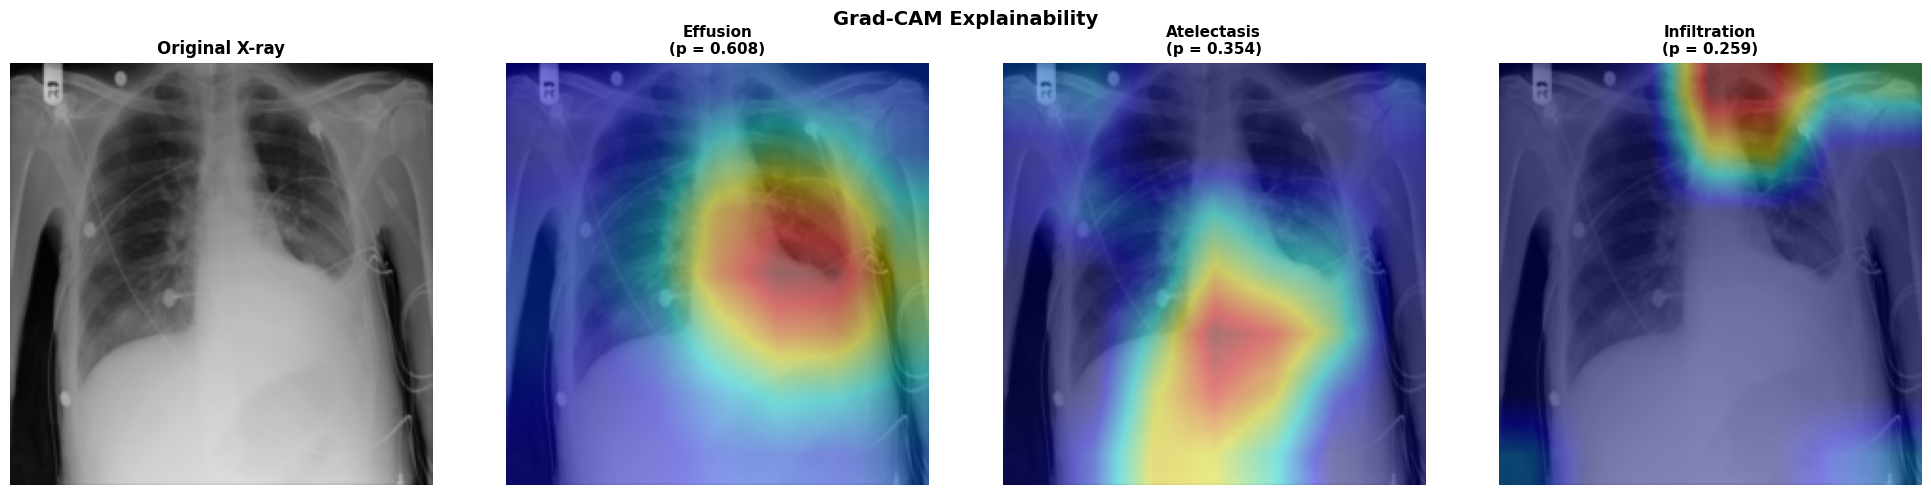

⬇️  Loading MedGemma (freeing GPU first)...
⚠️  MedGemma inference failed: 'torch._C._CudaDeviceProperties' object has no attribute 'total_mem'
   → Falling back to rule-based reasoning.
🔄 Unloading MedGemma, restoring CNN to GPU...
✅ CNN restored to cuda.

4️⃣  Clinical Reasoning (rule_based_fallback):
     Observations: Radiographic features moderately suggestive of effusion (CNN confidence: 60.8%). Radiographic features subtlely suggestive of atelectasis (CNN confidence: 35.4%)....
     Differentials:
       • Mucus plugging
       • Post-surgical atelectasis
       • Endobronchial lesion
       • Pleural effusion
       • CHF

5️⃣  Fusion:
     Agreement: 80.0%
     Contradictions: 1

6️⃣  Uncertainty: 48.7% (LOW)
     Significant disagreement or uncertainty. Professional review essential.

7️⃣  Risk: MODERATE — Schedule follow-up imaging and clinical correlation.

⚠️  AI-generated preliminary analysis for research purposes only. Not a substitute for professional medical evaluation

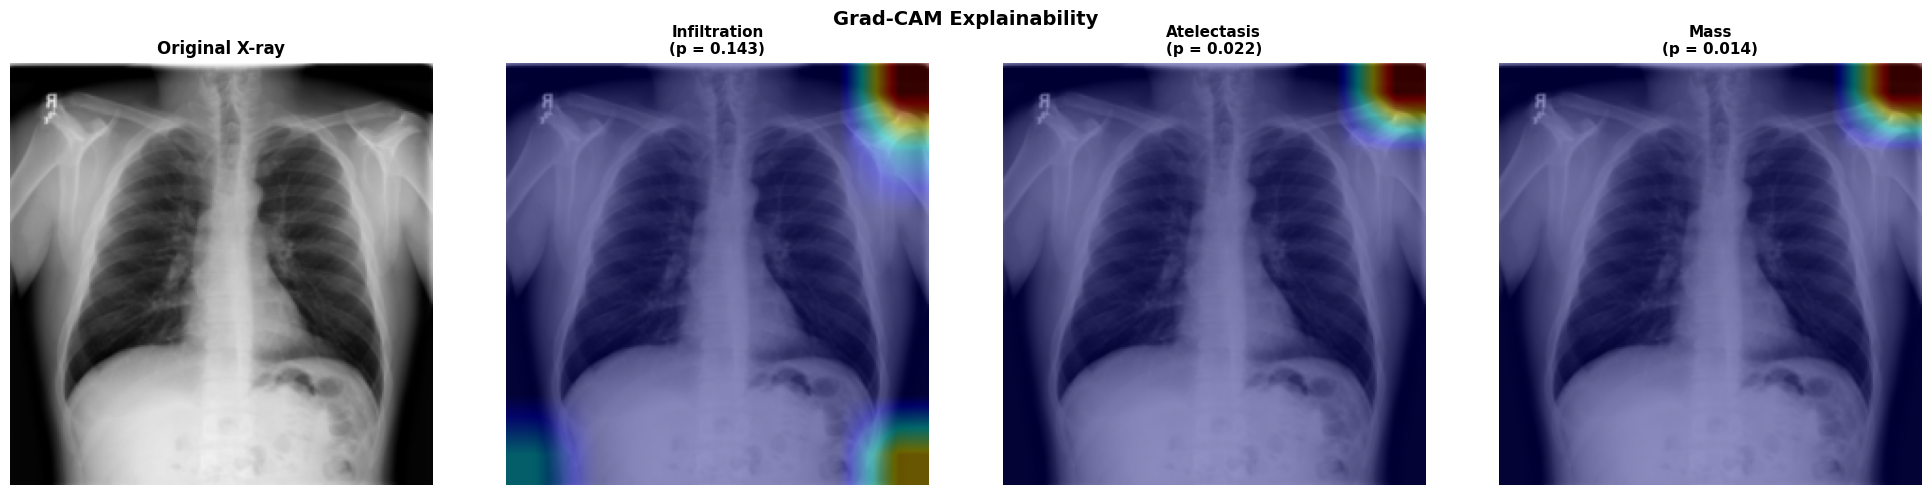

⬇️  Loading MedGemma (freeing GPU first)...
⚠️  MedGemma inference failed: 'torch._C._CudaDeviceProperties' object has no attribute 'total_mem'
   → Falling back to rule-based reasoning.
🔄 Unloading MedGemma, restoring CNN to GPU...
✅ CNN restored to cuda.

4️⃣  Clinical Reasoning (rule_based_fallback):
     Observations: No significant pathological findings detected....
     Differentials:
       • No acute pathology suggested

5️⃣  Fusion:
     Agreement: 100.0%
     Contradictions: 0

6️⃣  Uncertainty: 77.1% (HIGH)
     Strong agreement between modalities. Findings are reliable.

7️⃣  Risk: LOW — Routine follow-up. No immediate action required.

⚠️  AI-generated preliminary analysis for research purposes only. Not a substitute for professional medical evaluation.


✅ Pipeline complete. Generated 3 reports.


In [34]:
# --- 10.2 Run Pipeline on Multiple Positive Samples ---

positive_df = df_labels_real[
    df_labels_real[list(CFG.pathologies)].sum(axis=1) > 0
].sample(n=3, random_state=123).reset_index(drop=True)

demo_symptoms_list = [
    "Patient presents with persistent cough, low-grade fever, and shortness of breath for 5 days.",
    "Patient reports chest pain on deep inspiration and progressive fatigue over 2 weeks.",
    "Patient complains of wheezing, weight loss, and night sweats for 3 weeks.",
]

all_reports = []

for idx in range(len(positive_df)):
    ds = ChestXrayDataset(
        positive_df.iloc[[idx]].reset_index(drop=True),
        IMAGE_DIR, CFG.pathologies,
        transform=get_transforms(False),
        use_synthetic=False
    )
    img_tensor, lbl_tensor = ds[0]
    img_name = positive_df.iloc[idx]["Image Index"]
    symptoms = demo_symptoms_list[idx]

    single_report = run_full_pipeline(
        model, img_tensor, lbl_tensor, img_name,
        symptoms, CFG.pathologies, optimal_thresholds,
        medgemma_reasoner, fusion_module
    )
    all_reports.append(single_report)

print(f"\n\n{'=' * 60}")
print(f"✅ Pipeline complete. Generated {len(all_reports)} reports.")

In [35]:
# --- 10.3 Save Reports ---

REPORTS_PATH = os.path.join(CFG.data_dir, "pipeline_reports.json")

with open(REPORTS_PATH, "w") as f:
    json.dump(all_reports, f, indent=2, default=str)

print(f"✅ All reports saved to: {REPORTS_PATH}")
print(f"   Total reports: {len(all_reports)}")
print(f"   File size: {os.path.getsize(REPORTS_PATH) / 1024:.1f} KB")

✅ All reports saved to: ./data/pipeline_reports.json
   Total reports: 3
   File size: 7.4 KB


In [36]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("=" * 60)
print("🏥 MULTIMODAL CLINICAL AI ASSISTANT — SUMMARY")
print("=" * 60)

best_p = max((k, v) for k, v in eval_aucs.items() if k != "mean")

print(f"""
📊 MODEL PERFORMANCE:
   Mean AUC-ROC     : {eval_aucs['mean']:.4f}
   Best pathology   : {best_p[0]} ({best_p[1]:.4f})
   Training epochs  : {len(training_history['train_loss'])}
   Dataset size     : {len(df_labels_real):,} real X-ray images

📊 PER-PATHOLOGY RESULTS:""")

print(f"   {'Pathology':20s}  {'AUC':>6s}  {'Thresh':>6s}  {'F1':>6s}")
print(f"   {'-' * 45}")
for i, p in enumerate(CFG.pathologies):
    auc = eval_aucs[p]
    thresh = optimal_thresholds[p]
    y_bin = (y_pred[:, i] >= thresh).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(
        y_true[:, i], y_bin, average="binary", zero_division=0
    )
    marker = "⭐" if auc >= 0.8 else "✓" if auc >= 0.7 else "⚠️"
    print(f"   {marker} {p:18s}  {auc:.4f}  {thresh:.3f}  {f1:.3f}")

src = "unknown"
if isinstance(reasoning_output, dict):
    src = str(reasoning_output.get("source", "unknown"))

print(f"""
🔧 PIPELINE COMPONENTS:
   ✅ DenseNet121 CNN (fine-tuned on real X-rays)
   ✅ Optimal per-class thresholds
   ✅ Grad-CAM explainability (hook-free)
   ✅ Clinical reasoning ({src})
   ✅ CNN + Reasoning fusion module
   ✅ Uncertainty estimation
   ✅ Risk stratification
   ✅ Structured JSON reports

📁 SAVED ARTIFACTS:
   Model weights : {CFG.model_save_path}
   Reports       : {REPORTS_PATH}

📊 PIPELINE REPORTS GENERATED: {len(all_reports)}
""")

print("📋 REPORT SUMMARIES:")
print(f"   {'#':>3s}  {'Risk':>8s}  {'Confidence':>12s}  {'Source':>15s}  {'Contradictions':>15s}")
print(f"   {'-' * 60}")
for i, r in enumerate(all_reports):
    risk = r["risk_stratification"]["risk_level"]
    conf = r["uncertainty"]["final_confidence"]
    cont = r["fusion_results"]["num_contradictions"]
    rsrc = r["report_metadata"]["reasoning_source"]
    emoji = "🔴" if risk == "HIGH" else "🟡" if risk == "MODERATE" else "🟢"
    print(f"   {i+1:3d}  {emoji} {risk:6s}  {conf:10.1%}    {rsrc:>13s}  {cont:13d}")

print(f"\n{'=' * 60}")
print(f"⚠️  {CFG.disclaimer}")
print(f"{'=' * 60}")
print(f"\n✅ NOTEBOOK COMPLETE")

🏥 MULTIMODAL CLINICAL AI ASSISTANT — SUMMARY

📊 MODEL PERFORMANCE:
   Mean AUC-ROC     : 0.7382
   Best pathology   : Mass (0.6730)
   Training epochs  : 12
   Dataset size     : 4,995 real X-ray images

📊 PER-PATHOLOGY RESULTS:
   Pathology                AUC  Thresh      F1
   ---------------------------------------------
   ✓ Atelectasis         0.7362  0.249  0.327
   ✓ Cardiomegaly        0.7740  0.090  0.205
   ⭐ Effusion            0.8203  0.284  0.483
   ⚠️ Infiltration        0.6876  0.240  0.432
   ⚠️ Mass                0.6730  0.116  0.221

🔧 PIPELINE COMPONENTS:
   ✅ DenseNet121 CNN (fine-tuned on real X-rays)
   ✅ Optimal per-class thresholds
   ✅ Grad-CAM explainability (hook-free)
   ✅ Clinical reasoning (rule_based_fallback)
   ✅ CNN + Reasoning fusion module
   ✅ Uncertainty estimation
   ✅ Risk stratification
   ✅ Structured JSON reports

📁 SAVED ARTIFACTS:
   Model weights : ./models/cnn_chest_xray.pth
   Reports       : ./data/pipeline_reports.json

📊 PIPELINE REPO

FileUpload(value={'00000003_006.png': {'metadata': {'name': '00000003_006.png', 'type': 'image/png', 'size': 4…

Textarea(value='persistent cough for 2 weeks', description='📝 Symptoms:', layout=Layout(height='120px', width=…

Button(button_style='primary', description='🔍 Analyze X-Ray', layout=Layout(height='45px', width='200px'), sty…

⏳ Running full pipeline... (30-60s if using MedGemma)


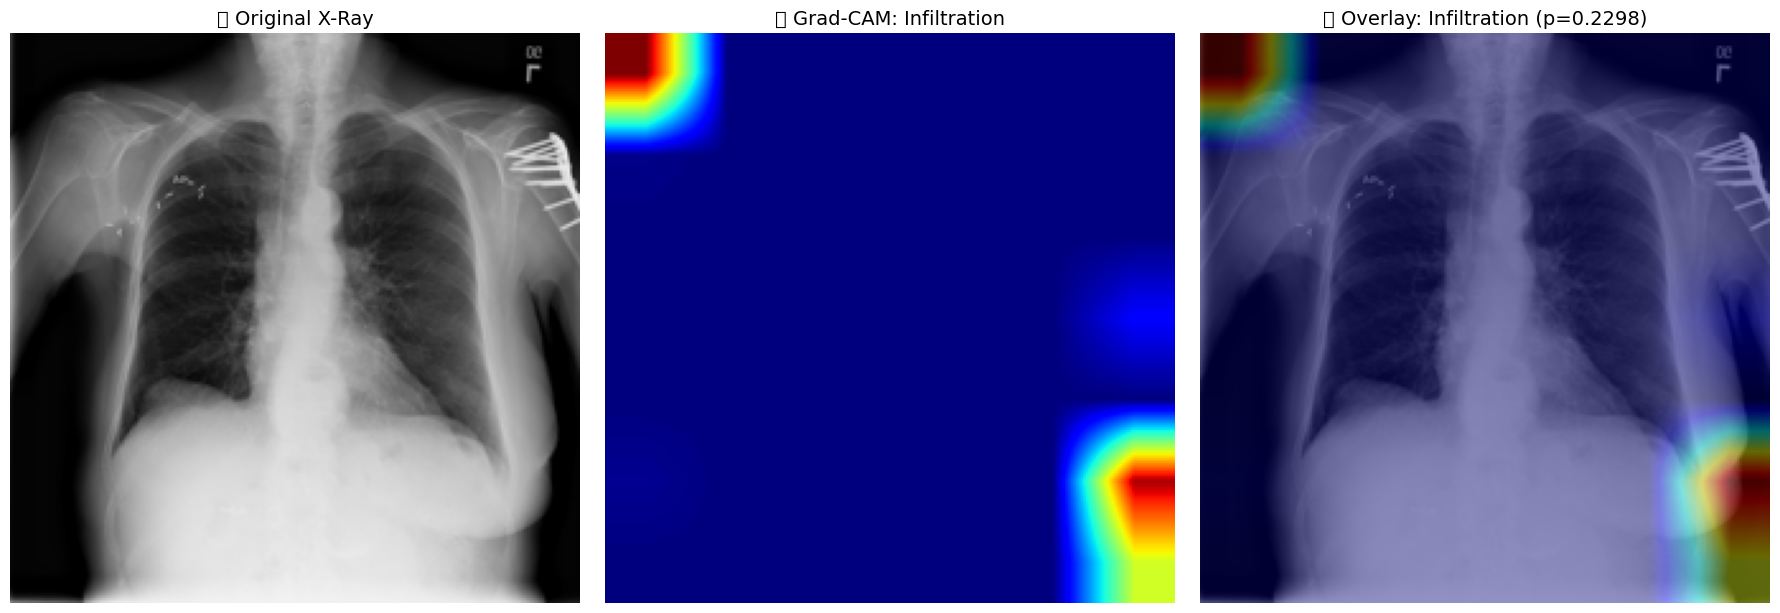


🧠 Running clinical reasoning...
⬇️  Loading MedGemma (freeing GPU first)...
   GPU memory available: 15.6 GB


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

✅ MedGemma loaded on GPU.
🔄 Unloading MedGemma, restoring CNN to GPU...
✅ CNN restored to cuda.

═══════════════════════════════════════════════════════
🏥 MULTIMODAL CLINICAL AI ANALYSIS REPORT
═══════════════════════════════════════════════════════

📡 REASONING ENGINE: 🧠 MedGemma 4B
🟡 RISK LEVEL: MODERATE
📋 ACTION: Schedule follow-up imaging and clinical correlation.
🔒 CONFIDENCE: 51.2% (MODERATE)

───────────────────────────────────────────────────────
📊 PATHOLOGY DETECTION
───────────────────────────────────────────────────────
  Pathology               Prob  Thresh   Fused       Result
  ───────────────────────────────────────────────────────
  Atelectasis           0.1096   0.249  0.1041  🟢 Negative
  Cardiomegaly          0.0495   0.090  0.0470  🟢 Negative
  Effusion              0.0781   0.284  0.0586  🟢 Negative
  Infiltration          0.2298   0.240  0.2183  🟢 Negative
  Mass                  0.0955   0.116  0.0716  🟢 Negative

─────────────────────────────────────────────────

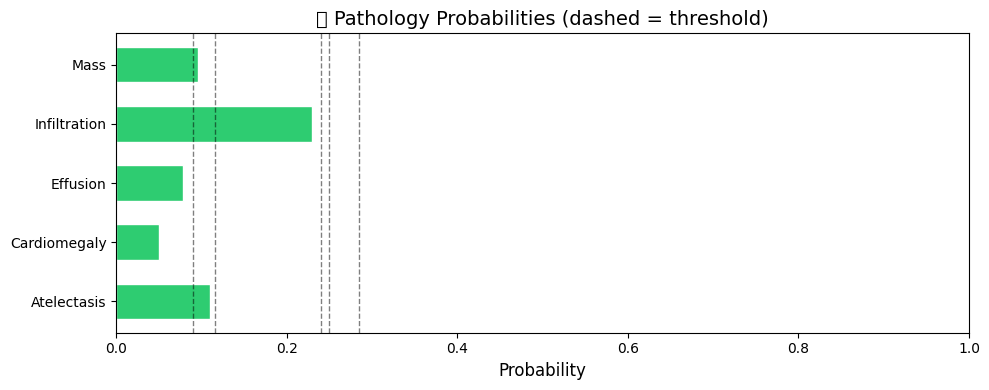


✅ Analysis complete. Upload another image to analyze again.


In [43]:
# ============================================================================
# SECTION 11 — INLINE INTERACTIVE INTERFACE (works in any Colab)
# ============================================================================

from google.colab import files
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from PIL import Image
import io


def run_analysis(upload_change):
    """Triggered when user uploads an image."""
    clear_output(wait=True)

    # Re-display widgets
    display(HTML("<h2>🏥 Multimodal Clinical AI Assistant</h2>"))
    display(HTML("<p>Upload a chest X-ray and enter symptoms below.</p>"))
    display(upload_widget)
    display(symptoms_widget)
    display(analyze_button)

    print("⏳ Processing...")


def analyze_clicked(b):
    """Run full pipeline on uploaded image + symptoms."""
    clear_output(wait=True)

    display(HTML("<h2>🏥 Multimodal Clinical AI Assistant</h2>"))
    display(upload_widget)
    display(symptoms_widget)
    display(analyze_button)

    # Check upload
    if not upload_widget.value:
        print("❌ Please upload a chest X-ray image first.")
        return

    symptoms_text = symptoms_widget.value.strip()
    if not symptoms_text:
        symptoms_text = "No symptoms provided."

    print("⏳ Running full pipeline... (30-60s if using MedGemma)")
    print("=" * 55)

    try:
        # Load uploaded image
        uploaded_file = list(upload_widget.value.values())[0]
        img_bytes = uploaded_file['content']
        pil_img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        # Preprocess
        transform = get_transforms(is_training=False)
        img_tensor = transform(pil_img)

        # CNN Prediction
        model.to(DEVICE)
        model.eval()
        disable_inplace_relu(model)

        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(DEVICE))
            probs = torch.sigmoid(logits).cpu().numpy()[0]

        cnn_preds = {p: float(probs[i]) for i, p in enumerate(CFG.pathologies)}

        # Grad-CAM
        grad_cam = GradCAM(model)
        top_idx = int(np.argsort(probs)[::-1][0])
        top_pathology = CFG.pathologies[top_idx]
        heatmap = grad_cam.generate(img_tensor.unsqueeze(0).to(DEVICE), top_idx)

        display_img = np.array(pil_img.resize((CFG.image_size, CFG.image_size))) / 255.0
        heatmap_color = cv2.applyColorMap(
            (heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET
        )
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0
        overlay = np.clip(0.4 * heatmap_color + 0.6 * display_img, 0, 1)

        # Show images side by side
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(display_img)
        axes[0].set_title("📷 Original X-Ray", fontsize=14)
        axes[0].axis("off")

        axes[1].imshow(heatmap, cmap="jet")
        axes[1].set_title(f"🔥 Grad-CAM: {top_pathology}", fontsize=14)
        axes[1].axis("off")

        axes[2].imshow(overlay)
        axes[2].set_title(f"🔥 Overlay: {top_pathology} (p={probs[top_idx]:.4f})", fontsize=14)
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

        # MedGemma Reasoning
        print("\n🧠 Running clinical reasoning...")
        reasoning = medgemma_reasoner.reason(pil_img, symptoms_text, cnn_preds)
        model.to(DEVICE)  # Ensure CNN back on GPU

        # Fusion
        fusion = fusion_module.fuse(cnn_preds, reasoning)

        # Uncertainty
        unc = UncertaintyEstimator.estimate(probs, fusion, reasoning)

        # Risk
        risk = risk_stratify(fusion["fused_pathology_scores"], unc)

        # ── Print Report ──
        source = reasoning.get("source", "unknown")
        source_label = "🧠 MedGemma 4B" if source == "medgemma" else "📐 Rule-Based Engine"
        risk_emoji = {"HIGH": "🔴", "MODERATE": "🟡", "LOW": "🟢"}.get(risk["risk_level"], "⚪")

        print("\n" + "═" * 55)
        print("🏥 MULTIMODAL CLINICAL AI ANALYSIS REPORT")
        print("═" * 55)

        print(f"\n📡 REASONING ENGINE: {source_label}")
        print(f"{risk_emoji} RISK LEVEL: {risk['risk_level']}")
        print(f"📋 ACTION: {risk['recommended_action']}")
        print(f"🔒 CONFIDENCE: {unc['final_confidence']:.1%} ({unc['confidence_level']})")

        print(f"\n{'─' * 55}")
        print("📊 PATHOLOGY DETECTION")
        print(f"{'─' * 55}")
        print(f"  {'Pathology':20s} {'Prob':>7s} {'Thresh':>7s} {'Fused':>7s} {'Result':>12s}")
        print(f"  {'─' * 55}")
        for p in CFG.pathologies:
            prob = cnn_preds[p]
            thresh = optimal_thresholds[p]
            fused = fusion["fused_pathology_scores"][p]
            marker = "🔴 POSITIVE" if prob >= thresh else "🟢 Negative"
            print(f"  {p:20s} {prob:7.4f} {thresh:7.3f} {fused:7.4f}  {marker}")

        print(f"\n{'─' * 55}")
        print(f"📌 OBSERVATIONS ({source_label})")
        print(f"{'─' * 55}")
        obs = str(reasoning.get('observations', 'N/A'))
        for line in obs.split('. '):
            line = line.strip()
            if line:
                print(f"  • {line}." if not line.endswith('.') else f"  • {line}")

        print(f"\n{'─' * 55}")
        print("📌 SYMPTOM CORRELATION")
        print(f"{'─' * 55}")
        sx = str(reasoning.get('symptom_correlation', 'N/A'))
        for line in sx.split('. '):
            line = line.strip()
            if line:
                print(f"  • {line}." if not line.endswith('.') else f"  • {line}")

        print(f"\n{'─' * 55}")
        print("📌 DIFFERENTIAL CONSIDERATIONS")
        print(f"{'─' * 55}")
        diff = reasoning.get('differential_considerations', [])
        if isinstance(diff, list):
            for i, d in enumerate(diff, 1):
                print(f"  {i}. {d}")
        else:
            print(f"  {diff}")

        print(f"\n{'─' * 55}")
        print("📌 RECOMMENDED FOLLOW-UP")
        print(f"{'─' * 55}")
        fu = str(reasoning.get('recommended_followup', 'N/A'))
        for line in fu.split('; '):
            line = line.strip()
            if line:
                print(f"  → {line}")

        # Full MedGemma raw reasoning
        raw = str(reasoning.get('raw_reasoning', ''))
        if source == "medgemma" and len(raw) > 50:
            print(f"\n{'─' * 55}")
            print("🧠 FULL MEDGEMMA REASONING")
            print(f"{'─' * 55}")
            for line in raw.split('\n'):
                print(f"  {line}")

        print(f"\n{'─' * 55}")
        print("🔗 CNN ↔ REASONING FUSION")
        print(f"{'─' * 55}")
        print(f"  Agreement      : {fusion['agreement_ratio']:.1%}")
        print(f"  Contradictions : {fusion['num_contradictions']}")
        if fusion['contradictions']:
            for c in fusion['contradictions']:
                print(f"  ⚠️  {c['pathology']}: CNN={c['cnn_says']}, "
                      f"MedGemma={c['llm_says']} (p={c['cnn_probability']})")

        print(f"\n  Fused Scores:")
        for p, s in fusion["fused_pathology_scores"].items():
            filled = int(s * 25)
            bar = "█" * filled + "░" * (25 - filled)
            print(f"  {p:20s}: {s:.4f} |{bar}|")

        print(f"\n{'─' * 55}")
        print("📊 CONFIDENCE BREAKDOWN")
        print(f"{'─' * 55}")
        print(f"  CNN Confidence     : {unc['cnn_confidence']:.1%}")
        print(f"  MedGemma Confidence: {unc['llm_confidence']:.1%}")
        print(f"  Agreement Ratio    : {unc['agreement_ratio']:.1%}")
        print(f"  Combined           : {unc['combined_confidence']:.1%}")
        print(f"  Contradiction Pen. : -{unc['contradiction_penalty']:.1%}")
        print(f"  ────────────────────────────")
        print(f"  FINAL CONFIDENCE   : {unc['final_confidence']:.1%} ({unc['confidence_level']})")
        print(f"  {unc['interpretation']}")

        print(f"\n{'═' * 55}")
        print(f"⚠️  {CFG.disclaimer}")
        print(f"{'═' * 55}")

        # Bar chart
        fig2, ax = plt.subplots(figsize=(10, 4))
        colors = ['#e74c3c' if cnn_preds[p] >= optimal_thresholds[p] else '#2ecc71'
                  for p in CFG.pathologies]
        bars = ax.barh(list(CFG.pathologies), [cnn_preds[p] for p in CFG.pathologies],
                       color=colors, edgecolor='white', height=0.6)
        for p in CFG.pathologies:
            ax.axvline(x=optimal_thresholds[p], color='black', linestyle='--',
                       alpha=0.5, linewidth=1)
        ax.set_xlabel("Probability", fontsize=12)
        ax.set_title("📊 Pathology Probabilities (dashed = threshold)", fontsize=14)
        ax.set_xlim(0, 1)
        plt.tight_layout()
        plt.show()

        print("\n✅ Analysis complete. Upload another image to analyze again.")

    except Exception as e:
        import traceback
        print(f"\n❌ Error:\n{str(e)}\n{traceback.format_exc()}")
        try:
            model.to(DEVICE)
        except:
            pass


# ── Create Widgets ──

upload_widget = widgets.FileUpload(
    accept='.png,.jpg,.jpeg,.dicom',
    multiple=False,
    description='📷 X-Ray:',
    layout=widgets.Layout(width='400px'),
)

symptoms_widget = widgets.Textarea(
    value='',
    placeholder='Enter patient symptoms here...\n\nExample: Persistent cough for 2 weeks, low-grade fever, shortness of breath on exertion.',
    description='📝 Symptoms:',
    layout=widgets.Layout(width='600px', height='120px'),
)

analyze_button = widgets.Button(
    description='🔍 Analyze X-Ray',
    button_style='primary',
    layout=widgets.Layout(width='200px', height='45px'),
    tooltip='Click to run full analysis pipeline',
)
analyze_button.on_click(analyze_clicked)

# ── Display ──
display(HTML("""
<h2>🏥 Multimodal Clinical AI Assistant</h2>
<p>Upload a <b>chest X-ray</b> and enter <b>patient symptoms</b>, then click <b>Analyze</b>.</p>
<p>Pipeline: CNN → Grad-CAM → MedGemma → Fusion → Uncertainty → Risk Report</p>
<hr>
"""))
display(upload_widget)
display(symptoms_widget)
display(analyze_button)

In [51]:
!pip install -q flask nest_asyncio

import nest_asyncio
nest_asyncio.apply()

from flask import Flask, request, render_template_string, send_file
from PIL import Image
from threading import Thread
import io
import base64
import gc
import uuid

app = Flask(__name__)

HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>Multimodal Clinical AI Assistant</title>
    <style>
        * { margin: 0; padding: 0; box-sizing: border-box; }
        body { font-family: 'Segoe UI', Arial, sans-serif; background: #0f1117; color: #e0e0e0; }
        .header { background: linear-gradient(135deg, #1a1a2e, #16213e); padding: 30px; text-align: center; border-bottom: 2px solid #0f3460; }
        .header h1 { font-size: 2em; color: #00d4ff; margin-bottom: 8px; }
        .header p { color: #8892b0; font-size: 1em; }
        .container { max-width: 1200px; margin: 30px auto; padding: 0 20px; }
        .input-section { background: #1a1a2e; border-radius: 12px; padding: 30px; margin-bottom: 30px; border: 1px solid #2a2a4a; }
        .input-section h2 { color: #00d4ff; margin-bottom: 20px; font-size: 1.3em; }
        .form-group { margin-bottom: 20px; }
        .form-group label { display: block; margin-bottom: 8px; color: #8892b0; font-weight: 600; }
        input[type="file"] { padding: 12px; background: #0f1117; border: 2px dashed #2a2a4a; border-radius: 8px; color: #e0e0e0; width: 100%; cursor: pointer; }
        input[type="file"]:hover { border-color: #00d4ff; }
        textarea { width: 100%; padding: 12px; background: #0f1117; border: 1px solid #2a2a4a; border-radius: 8px; color: #e0e0e0; font-size: 1em; resize: vertical; min-height: 100px; }
        textarea:focus { outline: none; border-color: #00d4ff; }
        .btn { background: linear-gradient(135deg, #00d4ff, #0099cc); color: #0f1117; border: none; padding: 15px 40px; font-size: 1.1em; font-weight: 700; border-radius: 8px; cursor: pointer; width: 100%; }
        .btn:hover { opacity: 0.9; }
        .btn:disabled { background: #444; cursor: wait; }
        .results { background: #1a1a2e; border-radius: 12px; padding: 30px; border: 1px solid #2a2a4a; }
        .risk-banner { padding: 20px; border-radius: 8px; margin-bottom: 25px; text-align: center; font-size: 1.2em; font-weight: 700; }
        .risk-HIGH { background: linear-gradient(135deg, #ff4444, #cc0000); color: white; }
        .risk-MODERATE { background: linear-gradient(135deg, #ffaa00, #cc8800); color: #1a1a2e; }
        .risk-LOW { background: linear-gradient(135deg, #00cc66, #009944); color: white; }
        .images-row { display: flex; gap: 15px; margin: 20px 0; flex-wrap: wrap; justify-content: center; }
        .images-row img { border-radius: 8px; border: 1px solid #2a2a4a; max-width: 100%; }
        .section { margin-top: 25px; }
        .section h3 { color: #00d4ff; margin-bottom: 12px; padding-bottom: 8px; border-bottom: 1px solid #2a2a4a; }
        .section p, .section li { color: #c0c0c0; line-height: 1.8; }
        .section ul { padding-left: 20px; }
        table { width: 100%; border-collapse: collapse; margin: 10px 0; }
        th { background: #0f1117; color: #00d4ff; padding: 10px; text-align: left; border-bottom: 2px solid #2a2a4a; }
        td { padding: 10px; border-bottom: 1px solid #1f1f3a; }
        .pos { color: #ff4444; font-weight: 700; }
        .neg { color: #00cc66; }
        .bar-container { background: #0f1117; border-radius: 4px; height: 20px; width: 150px; display: inline-block; vertical-align: middle; }
        .bar-fill { height: 100%; border-radius: 4px; }
        .disclaimer { background: #2a1a1a; border: 1px solid #ff4444; border-radius: 8px; padding: 15px; margin-top: 25px; color: #ff8888; text-align: center; }
        .loading { display: none; text-align: center; padding: 40px; }
        .loading.active { display: block; }
        .spinner { border: 4px solid #2a2a4a; border-top: 4px solid #00d4ff; border-radius: 50%; width: 40px; height: 40px; animation: spin 1s linear infinite; margin: 0 auto 15px; }
        @keyframes spin { 0% { transform: rotate(0deg); } 100% { transform: rotate(360deg); } }
        .confidence-grid { display: grid; grid-template-columns: 1fr 1fr; gap: 10px; }
        .confidence-item { background: #0f1117; padding: 10px; border-radius: 6px; }
        .confidence-label { color: #8892b0; font-size: 0.85em; }
        .confidence-value { color: #e0e0e0; font-size: 1.1em; font-weight: 600; }
    </style>
</head>
<body>

<div class="header">
    <h1>Multimodal Clinical AI Assistant</h1>
    <p>CNN + Grad-CAM + MedGemma 4B + Fusion Pipeline</p>
</div>

<div class="container">
    <div class="input-section">
        <h2>Upload Chest X-Ray and Enter Symptoms</h2>
        <form action="/analyze" method="post" enctype="multipart/form-data" id="analyzeForm">
            <div class="form-group">
                <label>Chest X-Ray Image (PNG, JPG)</label>
                <input type="file" name="xray" accept=".png,.jpg,.jpeg" required>
            </div>
            <div class="form-group">
                <label>Patient Symptoms and Clinical History</label>
                <textarea name="symptoms" placeholder="Example: 55-year-old male with persistent cough for 2 weeks, low-grade fever, shortness of breath on exertion. History of smoking 20 pack-years."></textarea>
            </div>
            <button type="submit" class="btn" id="submitBtn" onclick="this.disabled=true;this.innerText='Analyzing... (30-60s)';this.form.submit();">Analyze X-Ray</button>
        </form>
    </div>

    {% if result %}
    <div class="results">

        <div class="risk-banner risk-{{ result.risk_level }}">
            RISK LEVEL: {{ result.risk_level }} | {{ result.action }}
        </div>

        <div style="text-align:center; margin-bottom:15px;">
            <span style="color:#8892b0;">Reasoning Engine:</span>
            <strong style="color:#00d4ff;">{{ result.source_label }}</strong>
            &nbsp;&nbsp;|&nbsp;&nbsp;
            <span style="color:#8892b0;">Confidence:</span>
            <strong style="color:#e0e0e0;">{{ result.final_confidence }} ({{ result.confidence_level }})</strong>
        </div>

        <div class="images-row">
            <img src="data:image/png;base64,{{ result.original_b64 }}" width="300" title="Original">
            <img src="data:image/png;base64,{{ result.gradcam_b64 }}" width="300" title="Grad-CAM Overlay">
            <img src="data:image/png;base64,{{ result.chart_b64 }}" width="400" title="Probabilities">
        </div>

        <div class="section">
            <h3>Pathology Detection</h3>
            <table>
                <tr><th>Pathology</th><th>Probability</th><th>Threshold</th><th>Fused</th><th>Result</th><th>Bar</th></tr>
                {% for row in result.pathology_rows %}
                <tr>
                    <td>{{ row.name }}</td>
                    <td>{{ row.prob }}</td>
                    <td>{{ row.thresh }}</td>
                    <td>{{ row.fused }}</td>
                    <td class="{{ 'pos' if row.positive else 'neg' }}">{{ 'POSITIVE' if row.positive else 'Negative' }}</td>
                    <td><div class="bar-container"><div class="bar-fill" style="width:{{ row.bar_width }}%;background:{{ '#ff4444' if row.positive else '#00cc66' }};"></div></div></td>
                </tr>
                {% endfor %}
            </table>
        </div>

        <div class="section">
            <h3>Observations ({{ result.source_label }})</h3>
            <ul>{% for line in result.observations %}<li>{{ line }}</li>{% endfor %}</ul>
        </div>

        <div class="section">
            <h3>Symptom Correlation</h3>
            <ul>{% for line in result.symptom_corr %}<li>{{ line }}</li>{% endfor %}</ul>
        </div>

        <div class="section">
            <h3>Differential Considerations</h3>
            <ol>{% for d in result.differentials %}<li>{{ d }}</li>{% endfor %}</ol>
        </div>

        <div class="section">
            <h3>Recommended Follow-Up</h3>
            <ul>{% for f in result.followup %}<li>{{ f }}</li>{% endfor %}</ul>
        </div>

        {% if result.medgemma_raw %}
        <div class="section">
            <h3>Full MedGemma Reasoning</h3>
            <pre style="background:#0f1117;padding:15px;border-radius:8px;white-space:pre-wrap;color:#c0c0c0;font-size:0.9em;">{{ result.medgemma_raw }}</pre>
        </div>
        {% endif %}

        <div class="section">
            <h3>CNN / Reasoning Fusion</h3>
            <p>Agreement: {{ result.agreement }} | Contradictions: {{ result.num_contradictions }}</p>
            {% if result.contradictions %}
            <ul>{% for c in result.contradictions %}<li style="color:#ff8888;">{{ c }}</li>{% endfor %}</ul>
            {% endif %}
        </div>

        <div class="section">
            <h3>Confidence Breakdown</h3>
            <div class="confidence-grid">
                <div class="confidence-item"><div class="confidence-label">CNN Confidence</div><div class="confidence-value">{{ result.cnn_conf }}</div></div>
                <div class="confidence-item"><div class="confidence-label">MedGemma Confidence</div><div class="confidence-value">{{ result.llm_conf }}</div></div>
                <div class="confidence-item"><div class="confidence-label">Agreement Ratio</div><div class="confidence-value">{{ result.agreement }}</div></div>
                <div class="confidence-item"><div class="confidence-label">Final Confidence</div><div class="confidence-value">{{ result.final_confidence }} ({{ result.confidence_level }})</div></div>
            </div>
        </div>

        <div class="disclaimer">
            {{ result.disclaimer }}
        </div>
    </div>
    {% endif %}

</div>
</body>
</html>
"""


def numpy_to_b64(img_array):
    pil = Image.fromarray((img_array * 255).astype(np.uint8) if img_array.max() <= 1.0 else img_array.astype(np.uint8))
    buf = io.BytesIO()
    pil.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")


@app.route("/", methods=["GET"])
def index():
    return render_template_string(HTML_TEMPLATE, result=None)


@app.route("/analyze", methods=["POST"])
def analyze():
    try:
        file = request.files["xray"]
        symptoms_text = request.form.get("symptoms", "No symptoms provided.")
        if not symptoms_text.strip():
            symptoms_text = "No symptoms provided."

        pil_img = Image.open(file.stream).convert("RGB")

        transform = get_transforms(is_training=False)
        img_tensor = transform(pil_img)

        model.to(DEVICE)
        model.eval()
        disable_inplace_relu(model)

        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(DEVICE))
            probs = torch.sigmoid(logits).cpu().numpy()[0]

        cnn_preds = {p: float(probs[i]) for i, p in enumerate(CFG.pathologies)}

        grad_cam = GradCAM(model)
        top_idx = int(np.argsort(probs)[::-1][0])
        top_pathology = CFG.pathologies[top_idx]
        heatmap = grad_cam.generate(img_tensor.unsqueeze(0).to(DEVICE), top_idx)

        display_img = np.array(pil_img.resize((CFG.image_size, CFG.image_size))) / 255.0
        heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0
        overlay = np.clip(0.4 * heatmap_color + 0.6 * display_img, 0, 1)

        original_b64 = numpy_to_b64(display_img)
        gradcam_b64 = numpy_to_b64(overlay)

        fig, ax = plt.subplots(figsize=(8, 3.5))
        colors = ['#e74c3c' if cnn_preds[p] >= optimal_thresholds[p] else '#2ecc71' for p in CFG.pathologies]
        ax.barh(list(CFG.pathologies), [cnn_preds[p] for p in CFG.pathologies], color=colors, edgecolor='white', height=0.6)
        for p in CFG.pathologies:
            ax.axvline(x=optimal_thresholds[p], color='black', linestyle='--', alpha=0.4, linewidth=1)
        ax.set_xlabel("Probability")
        ax.set_title("Pathology Probabilities (dashed = threshold)")
        ax.set_xlim(0, 1)
        plt.tight_layout()
        buf = io.BytesIO()
        fig.savefig(buf, format="png", dpi=100, bbox_inches="tight", facecolor="#0f1117")
        plt.close(fig)
        chart_b64 = base64.b64encode(buf.getvalue()).decode("utf-8")

        reasoning = medgemma_reasoner.reason(pil_img, symptoms_text, cnn_preds)
        model.to(DEVICE)

        fusion = fusion_module.fuse(cnn_preds, reasoning)
        unc = UncertaintyEstimator.estimate(probs, fusion, reasoning)
        risk = risk_stratify(fusion["fused_pathology_scores"], unc)

        source = reasoning.get("source", "unknown")
        source_label = "MedGemma 4B" if source == "medgemma" else "Rule-Based Engine"

        pathology_rows = []
        for p in CFG.pathologies:
            prob = cnn_preds[p]
            thresh = optimal_thresholds[p]
            fused = fusion["fused_pathology_scores"][p]
            pathology_rows.append({
                "name": p,
                "prob": f"{prob:.4f}",
                "thresh": f"{thresh:.3f}",
                "fused": f"{fused:.4f}",
                "positive": prob >= thresh,
                "bar_width": int(prob * 100),
            })

        obs_text = str(reasoning.get("observations", "N/A"))
        observations = [line.strip() + "." if not line.strip().endswith(".") else line.strip() for line in obs_text.split(". ") if line.strip()]

        sx_text = str(reasoning.get("symptom_correlation", "N/A"))
        symptom_corr = [line.strip() + "." if not line.strip().endswith(".") else line.strip() for line in sx_text.split(". ") if line.strip()]

        diff = reasoning.get("differential_considerations", [])
        if isinstance(diff, list):
            differentials = [str(d) for d in diff]
        else:
            differentials = [str(diff)]

        fu_text = str(reasoning.get("recommended_followup", "N/A"))
        followup = [line.strip() for line in fu_text.split("; ") if line.strip()]

        contradiction_strs = []
        if fusion["contradictions"]:
            for c in fusion["contradictions"]:
                contradiction_strs.append(c["pathology"] + ": CNN=" + c["cnn_says"] + ", MedGemma=" + c["llm_says"] + " (p=" + str(c["cnn_probability"]) + ")")

        medgemma_raw = ""
        raw = str(reasoning.get("raw_reasoning", ""))
        if source == "medgemma" and len(raw) > 50:
            medgemma_raw = raw

        result = {
            "risk_level": risk["risk_level"],
            "action": risk["recommended_action"],
            "source_label": source_label,
            "final_confidence": f"{unc['final_confidence']:.1%}",
            "confidence_level": unc["confidence_level"],
            "original_b64": original_b64,
            "gradcam_b64": gradcam_b64,
            "chart_b64": chart_b64,
            "pathology_rows": pathology_rows,
            "observations": observations,
            "symptom_corr": symptom_corr,
            "differentials": differentials,
            "followup": followup,
            "agreement": f"{fusion['agreement_ratio']:.1%}",
            "num_contradictions": fusion["num_contradictions"],
            "contradictions": contradiction_strs,
            "cnn_conf": f"{unc['cnn_confidence']:.1%}",
            "llm_conf": f"{unc['llm_confidence']:.1%}",
            "medgemma_raw": medgemma_raw,
            "disclaimer": CFG.disclaimer,
        }

        gc.collect()
        return render_template_string(HTML_TEMPLATE, result=result)

    except Exception as e:
        import traceback
        try:
            model.to(DEVICE)
        except:
            pass
        gc.collect()
        return "<h2>Error</h2><pre>" + traceback.format_exc() + "</pre>"


port = 5000
print("Starting Flask server on port " + str(port) + "...")

from google.colab.output import eval_js
public_url = eval_js("google.colab.kernel.proxyPort({})".format(port))
print("")
print("=" * 55)
print("OPEN THIS URL IN YOUR BROWSER:")
print(str(public_url))
print("=" * 55)
print("")

app.run(port=port, debug=False, use_reloader=False)

Starting Flask server on port 5000...

OPEN THIS URL IN YOUR BROWSER:
https://5000-gpu-t4-s-2v78t6z1mapri-b.us-west4-1.prod.colab.dev

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 10:49:42] "GET / HTTP/1.1" 200 -


⬇️  Loading MedGemma (freeing GPU first)...
   GPU memory available: 15.6 GB


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

✅ MedGemma loaded on GPU.
🔄 Unloading MedGemma, restoring CNN to GPU...
✅ CNN restored to cuda.


INFO:werkzeug:127.0.0.1 - - [14/Feb/2026 10:51:55] "POST /analyze HTTP/1.1" 200 -


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.1 MB/s eta 0:00:00
GENERATING PROOF ARTIFACTS

Step 1: Upload the chest X-ray you want to capture proof for



Saving 00000005_000.png to 00000005_000.png

Image loaded: 00000005_000.png

Enter symptoms (or press Enter for default): 55-year-old male with persistent cough for 2 weeks

Running pipeline...
⬇️  Loading MedGemma (freeing GPU first)...
   GPU memory available: 15.6 GB


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

✅ MedGemma loaded on GPU.
🔄 Unloading MedGemma, restoring CNN to GPU...
✅ CNN restored to cuda.
Saving artifacts...

  [1/5] JSON report saved: clinical_report_2026-02-14_10-47-35.json
  [2/5] Original image saved: original_xray_2026-02-14_10-47-35.png
  [3/5] Grad-CAM overlay saved: gradcam_overlay_2026-02-14_10-47-35.png
  [4/5] Bar chart saved: pathology_chart_2026-02-14_10-47-35.png


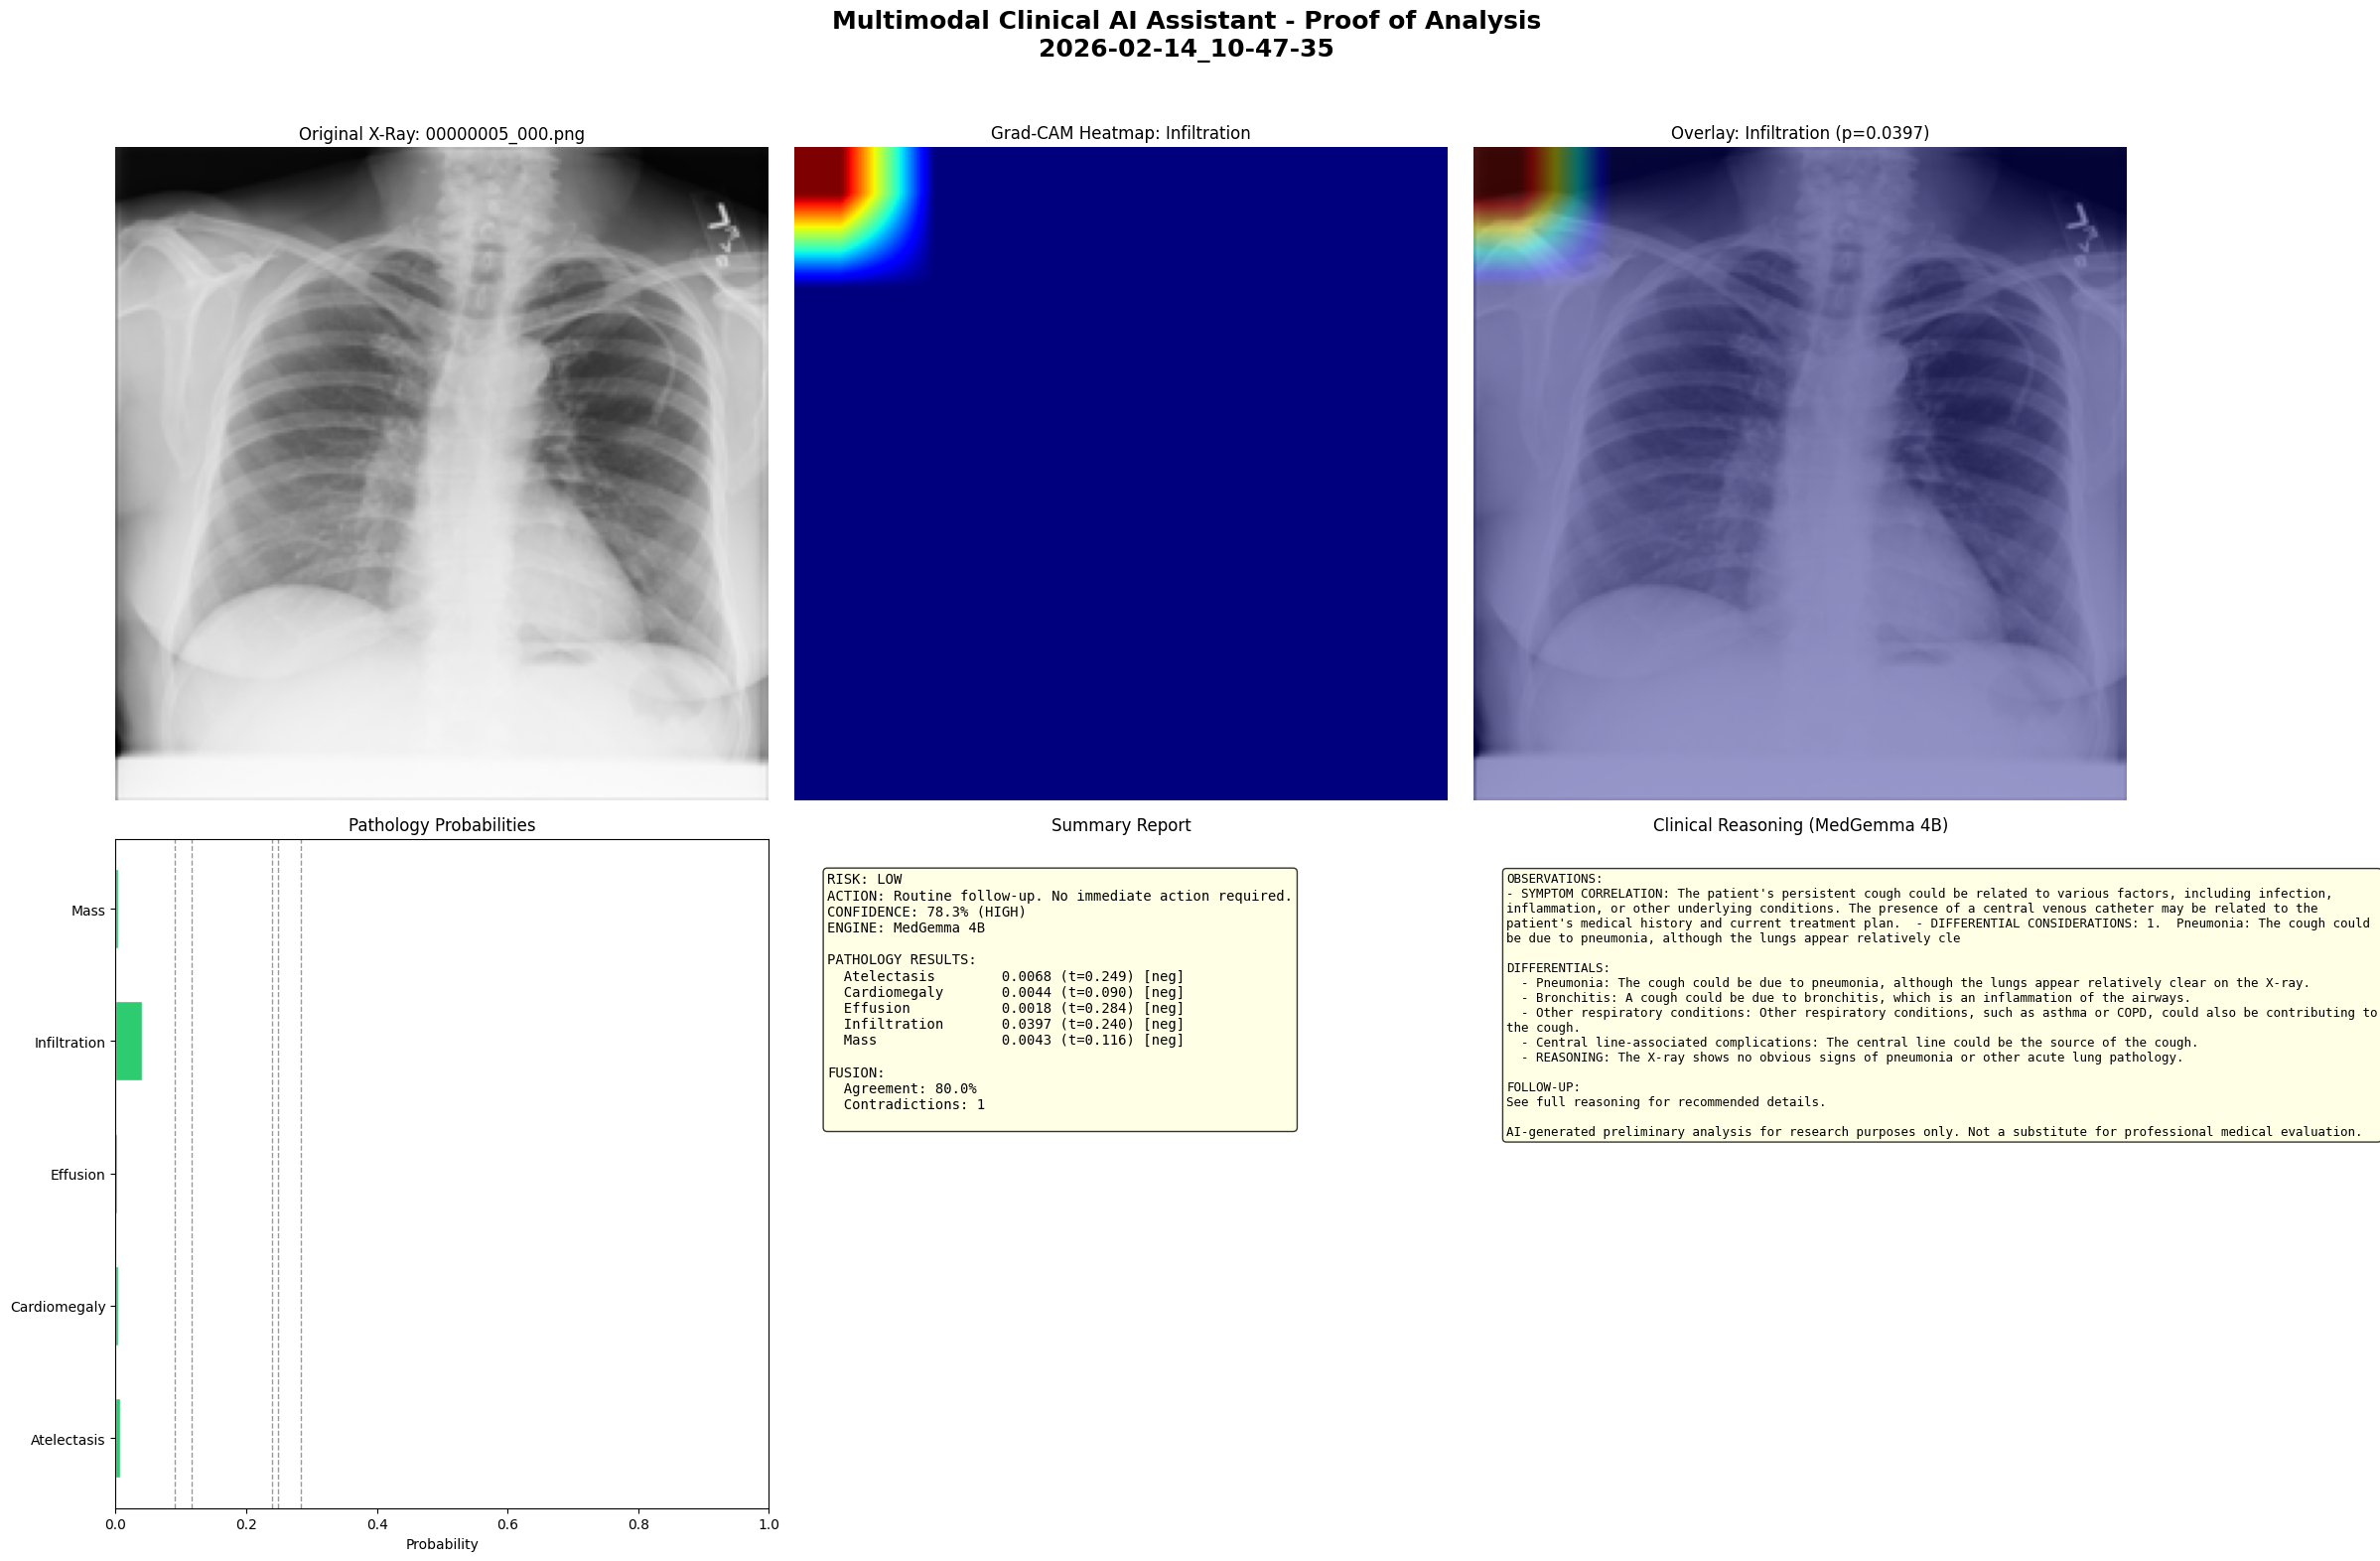

  [5/5] Full proof image saved: full_proof_2026-02-14_10-47-35.png

ALL PROOF ARTIFACTS SAVED

  1. clinical_report_2026-02-14_10-47-35.json       (structured report)
  2. original_xray_2026-02-14_10-47-35.png      (original X-ray)
  3. gradcam_overlay_2026-02-14_10-47-35.png  (Grad-CAM heatmap)
  4. pathology_chart_2026-02-14_10-47-35.png (probability chart)
  5. full_proof_2026-02-14_10-47-35.png       (all-in-one proof)




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Done! All proof artifacts generated and downloaded.


In [50]:
!pip install -q imgkit pdfkit kaleido

import json
import base64
from datetime import datetime
from google.colab import files as colab_files
from PIL import Image as PILImage
import io


def generate_proof_report(
    image_path, symptoms_text,
    cnn_preds, reasoning, fusion, unc, risk,
    display_img, overlay, chart_b64_or_fig=None
):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    source = reasoning.get("source", "unknown")
    source_label = "MedGemma 4B" if source == "medgemma" else "Rule-Based Engine"

    report_json = {
        "report_metadata": {
            "system": "Multimodal Clinical AI Assistant",
            "version": "1.0",
            "generated_at": timestamp,
            "reasoning_engine": source_label,
            "disclaimer": CFG.disclaimer,
        },
        "patient_input": {
            "image": image_path,
            "symptoms": symptoms_text,
        },
        "risk_stratification": risk,
        "confidence": {
            "cnn_confidence": unc["cnn_confidence"],
            "llm_confidence": unc["llm_confidence"],
            "agreement_ratio": unc["agreement_ratio"],
            "combined_confidence": unc["combined_confidence"],
            "contradiction_penalty": unc["contradiction_penalty"],
            "final_confidence": unc["final_confidence"],
            "confidence_level": unc["confidence_level"],
            "interpretation": unc["interpretation"],
        },
        "cnn_predictions": cnn_preds,
        "thresholded_predictions": {},
        "clinical_reasoning": {
            "observations": reasoning.get("observations", ""),
            "symptom_correlation": reasoning.get("symptom_correlation", ""),
            "differential_considerations": reasoning.get("differential_considerations", []),
            "recommended_followup": reasoning.get("recommended_followup", ""),
        },
        "fusion_results": {
            "agreement_ratio": fusion["agreement_ratio"],
            "num_contradictions": fusion["num_contradictions"],
            "contradictions": fusion["contradictions"],
            "fused_scores": fusion["fused_pathology_scores"],
        },
    }

    for p in CFG.pathologies:
        prob = cnn_preds[p]
        thresh = optimal_thresholds[p]
        report_json["thresholded_predictions"][p] = {
            "probability": round(prob, 4),
            "threshold": round(thresh, 3),
            "prediction": "POSITIVE" if prob >= thresh else "NEGATIVE",
        }

    if source == "medgemma":
        report_json["medgemma_raw_output"] = reasoning.get("raw_reasoning", "")

    return report_json


def save_all_proof(symptoms_text="Demo symptoms"):

    print("=" * 55)
    print("GENERATING PROOF ARTIFACTS")
    print("=" * 55)

    print("")
    print("Step 1: Upload the chest X-ray you want to capture proof for")
    print("")

    uploaded = colab_files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    filename = list(uploaded.keys())[0]
    img_bytes = uploaded[filename]
    pil_img = PILImage.open(io.BytesIO(img_bytes)).convert("RGB")

    print("")
    print("Image loaded: " + filename)
    print("")

    symptoms_text = input("Enter symptoms (or press Enter for default): ")
    if not symptoms_text.strip():
        symptoms_text = "Patient presents with persistent cough, low-grade fever, and shortness of breath for 5 days."

    print("")
    print("Running pipeline...")

    transform = get_transforms(is_training=False)
    img_tensor = transform(pil_img)

    model.to(DEVICE)
    model.eval()
    disable_inplace_relu(model)

    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0).to(DEVICE))
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    cnn_preds = {p: float(probs[i]) for i, p in enumerate(CFG.pathologies)}

    grad_cam = GradCAM(model)
    top_idx = int(np.argsort(probs)[::-1][0])
    top_pathology = CFG.pathologies[top_idx]
    heatmap = grad_cam.generate(img_tensor.unsqueeze(0).to(DEVICE), top_idx)

    display_img = np.array(pil_img.resize((CFG.image_size, CFG.image_size))) / 255.0
    heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0
    overlay = np.clip(0.4 * heatmap_color + 0.6 * display_img, 0, 1)

    reasoning = medgemma_reasoner.reason(pil_img, symptoms_text, cnn_preds)
    model.to(DEVICE)

    fusion_res = fusion_module.fuse(cnn_preds, reasoning)
    unc = UncertaintyEstimator.estimate(probs, fusion_res, reasoning)
    risk = risk_stratify(fusion_res["fused_pathology_scores"], unc)

    source = reasoning.get("source", "unknown")
    source_label = "MedGemma 4B" if source == "medgemma" else "Rule-Based Engine"
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    print("Saving artifacts...")
    print("")

    # 1. Save JSON report
    report_json = generate_proof_report(
        filename, symptoms_text,
        cnn_preds, reasoning, fusion_res, unc, risk,
        display_img, overlay
    )

    json_filename = "clinical_report_" + timestamp + ".json"
    with open(json_filename, "w") as f:
        json.dump(report_json, f, indent=2, default=str)
    print("  [1/5] JSON report saved: " + json_filename)

    # 2. Save original image
    orig_filename = "original_xray_" + timestamp + ".png"
    pil_img.save(orig_filename)
    print("  [2/5] Original image saved: " + orig_filename)

    # 3. Save Grad-CAM overlay
    gradcam_filename = "gradcam_overlay_" + timestamp + ".png"
    overlay_pil = PILImage.fromarray((overlay * 255).astype(np.uint8))
    overlay_pil.save(gradcam_filename)
    print("  [3/5] Grad-CAM overlay saved: " + gradcam_filename)

    # 4. Save bar chart
    chart_filename = "pathology_chart_" + timestamp + ".png"
    fig_chart, ax = plt.subplots(figsize=(10, 4))
    colors = ['#e74c3c' if cnn_preds[p] >= optimal_thresholds[p] else '#2ecc71' for p in CFG.pathologies]
    ax.barh(list(CFG.pathologies), [cnn_preds[p] for p in CFG.pathologies], color=colors, edgecolor='white', height=0.6)
    for p in CFG.pathologies:
        ax.axvline(x=optimal_thresholds[p], color='black', linestyle='--', alpha=0.4, linewidth=1)
    ax.set_xlabel("Probability")
    ax.set_title("Pathology Probabilities (dashed = threshold)")
    ax.set_xlim(0, 1)
    plt.tight_layout()
    fig_chart.savefig(chart_filename, dpi=150, bbox_inches="tight")
    plt.close(fig_chart)
    print("  [4/5] Bar chart saved: " + chart_filename)

    # 5. Save full proof figure (all-in-one)
    proof_filename = "full_proof_" + timestamp + ".png"

    fig_proof, axes = plt.subplots(2, 3, figsize=(24, 16))
    fig_proof.suptitle(
        "Multimodal Clinical AI Assistant - Proof of Analysis\n" + timestamp,
        fontsize=18, fontweight="bold", y=0.98
    )

    axes[0, 0].imshow(display_img)
    axes[0, 0].set_title("Original X-Ray: " + filename, fontsize=12)
    axes[0, 0].axis("off")

    axes[0, 1].imshow(heatmap, cmap="jet")
    axes[0, 1].set_title("Grad-CAM Heatmap: " + top_pathology, fontsize=12)
    axes[0, 1].axis("off")

    axes[0, 2].imshow(overlay)
    axes[0, 2].set_title("Overlay: " + top_pathology + " (p=" + f"{probs[top_idx]:.4f}" + ")", fontsize=12)
    axes[0, 2].axis("off")

    ax_bar = axes[1, 0]
    colors = ['#e74c3c' if cnn_preds[p] >= optimal_thresholds[p] else '#2ecc71' for p in CFG.pathologies]
    ax_bar.barh(list(CFG.pathologies), [cnn_preds[p] for p in CFG.pathologies], color=colors, edgecolor='white', height=0.6)
    for p in CFG.pathologies:
        ax_bar.axvline(x=optimal_thresholds[p], color='black', linestyle='--', alpha=0.4, linewidth=1)
    ax_bar.set_xlabel("Probability")
    ax_bar.set_title("Pathology Probabilities", fontsize=12)
    ax_bar.set_xlim(0, 1)

    report_text = "RISK: " + risk["risk_level"] + "\n"
    report_text += "ACTION: " + risk["recommended_action"] + "\n"
    report_text += "CONFIDENCE: " + f"{unc['final_confidence']:.1%}" + " (" + unc["confidence_level"] + ")\n"
    report_text += "ENGINE: " + source_label + "\n\n"
    report_text += "PATHOLOGY RESULTS:\n"
    for p in CFG.pathologies:
        prob = cnn_preds[p]
        thresh = optimal_thresholds[p]
        fused = fusion_res["fused_pathology_scores"][p]
        pred = "POS" if prob >= thresh else "neg"
        report_text += f"  {p:18s} {prob:.4f} (t={thresh:.3f}) [{pred}]\n"
    report_text += "\nFUSION:\n"
    report_text += "  Agreement: " + f"{fusion_res['agreement_ratio']:.1%}" + "\n"
    report_text += "  Contradictions: " + str(fusion_res["num_contradictions"]) + "\n"

    axes[1, 1].text(0.05, 0.95, report_text, transform=axes[1, 1].transAxes,
                    fontsize=10, verticalalignment="top", fontfamily="monospace",
                    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8))
    axes[1, 1].set_title("Summary Report", fontsize=12)
    axes[1, 1].axis("off")

    reasoning_text = "OBSERVATIONS:\n"
    obs = str(reasoning.get("observations", "N/A"))
    reasoning_text += obs[:400] + "\n\n"
    reasoning_text += "DIFFERENTIALS:\n"
    diff = reasoning.get("differential_considerations", [])
    if isinstance(diff, list):
        for d in diff[:5]:
            reasoning_text += "  - " + str(d) + "\n"
    reasoning_text += "\nFOLLOW-UP:\n"
    fu = str(reasoning.get("recommended_followup", "N/A"))
    reasoning_text += fu[:300] + "\n"
    reasoning_text += "\n" + CFG.disclaimer

    axes[1, 2].text(0.05, 0.95, reasoning_text, transform=axes[1, 2].transAxes,
                    fontsize=9, verticalalignment="top", fontfamily="monospace",
                    wrap=True,
                    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8))
    axes[1, 2].set_title("Clinical Reasoning (" + source_label + ")", fontsize=12)
    axes[1, 2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig_proof.savefig(proof_filename, dpi=150, bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close(fig_proof)
    print("  [5/5] Full proof image saved: " + proof_filename)

    # Print summary
    print("")
    print("=" * 55)
    print("ALL PROOF ARTIFACTS SAVED")
    print("=" * 55)
    print("")
    print("  1. " + json_filename + "       (structured report)")
    print("  2. " + orig_filename + "      (original X-ray)")
    print("  3. " + gradcam_filename + "  (Grad-CAM heatmap)")
    print("  4. " + chart_filename + " (probability chart)")
    print("  5. " + proof_filename + "       (all-in-one proof)")
    print("")

    # Download all files
    print("Downloading all files to your computer...")
    print("")

    for f in [json_filename, orig_filename, gradcam_filename, chart_filename, proof_filename]:
        try:
            colab_files.download(f)
        except Exception as e:
            print("  Could not auto-download " + f + ": " + str(e))

    print("")
    print("Done! All proof artifacts generated and downloaded.")
    print("=" * 55)


save_all_proof()